In [4]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import cv2
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import time
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from numba import jit
from pathlib import Path
from scipy.spatial import KDTree
#import tables

In [5]:
x = utils.get_data(directory= r'D:\runs\Run_33_66_72_1_2021-06-24')

#x = utils.get_data(test=True)

<AxesSubplot:>

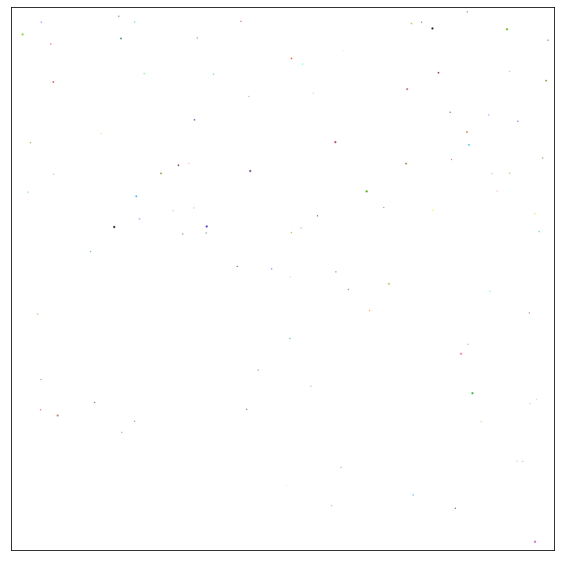

In [6]:
f, ax = plt.subplots(figsize=(10,10))
plot.plot_colony(x,time=35000)


# Assign mother cells

In [39]:
df = x.positions
df['mother_cell'] = -1
for ID in df[df.Timestep==0].ID.unique():
    idx = df[df['ID'] ==ID].index
    df.loc[idx,'mother_cell'] = ID
df

,Timestep,ID,type,radius,x,y,z,mother_cell
0,0,95,2,4.450000e-07,0.000025,0.000018,0.000002,95
1,0,11,1,9.600000e-07,0.000097,0.000027,0.000004,11
2,0,9,1,9.550000e-07,0.000193,0.000002,0.000005,9
3,0,85,2,4.845000e-07,0.000213,0.000014,0.000005,85
4,0,75,2,4.795000e-07,0.000125,0.000060,0.000005,75
...,...,...,...,...,...,...,...,...
1509472,35000,23090,2,4.200998e-07,0.000369,0.000451,0.000010,-1
1509473,35000,5557,2,4.937473e-07,0.000368,0.000452,0.000010,-1
1509474,35000,31029,2,4.517007e-07,0.000368,0.000452,0.000010,-1
1509475,35000,35847,2,4.201434e-07,0.000370,0.000452,0.000010,-1


In [40]:
arr = df[df.Timestep==1000][['x','y']].to_numpy()
tree = KDTree(arr)
dd, ii = tree.query(arr, k=2)
dd[:,1],ii[:,1]

(array([1.51795916e-05, 1.41743030e-06, 1.31605262e-06, 1.41743030e-06,
        2.29399862e-05, 4.29467344e-05, 3.41760150e-05, 1.31605262e-06,
        3.40219476e-05, 4.00169964e-05, 1.99022612e-05, 1.54958606e-06,
        3.50202798e-05, 1.54958606e-06, 1.51795916e-05, 1.34321443e-05,
        5.72349544e-05, 1.34321443e-05, 5.85491247e-05, 2.56766431e-05,
        1.89736660e-05, 1.00498756e-05, 4.15823280e-05, 3.40219047e-05,
        3.22948912e-05, 1.36014705e-05, 1.04521881e-06, 1.70000000e-05,
        3.22948912e-05, 1.00498756e-05, 1.04521881e-06, 3.50570963e-05,
        1.36014705e-05, 1.36014705e-05, 1.81107703e-05, 1.89736660e-05,
        1.36014705e-05, 3.53411941e-05, 2.45568728e-05, 1.98567369e-05,
        3.53411941e-05, 3.76198086e-05, 5.70897539e-05, 1.11803399e-05,
        1.11803399e-05, 1.98567369e-05, 1.58113883e-05, 2.96966328e-05,
        2.82842712e-05, 3.52567724e-05, 2.89243111e-05, 2.99917072e-05,
        3.70129707e-05, 3.43182496e-05, 1.87882942e-05, 1.308625

In [41]:
df[df.Timestep==1000].reset_index(drop=True).loc[ii[:,1],'ID'].values

array([ 15,  11,   9, 104, 105,  11,  53, 105,   9,  48,  95,  27,  99,
       103,  95,  93,  44,  58,  87,  33,  33,   1,  44,  16,  30,  42,
        61,  90,  44,  71, 100,  50,  87,  19,  19,   8,  86,  40,  82,
        24,  34,  24,  68,  97,  63,  82,   2,  54,  92,  51, 107,  22,
        54, 106,   2,  80,  80,  13,  54,  10,  17,  73,  17, 106,  31,
       107,   5,   6,  46,  65,  78,  14,   5,  55, 108,  28,  46,  20,
         6,  35,  74,  45,  50,  74,  72,  47,  34,  35,  94,  76,  77,
        67,  39,  34,  57,  38,  12,  37, 101, 102, 101,  56,  89,  26,
        56,  91,  52, 102])

In [43]:
df[(df['mother_cell'] ==-1) & (df.Timestep==1000)]
#s = pd.Series(ii[:,1],index=df[df.Timestep==1000].index)
s = pd.Series(df[df.Timestep==1000].reset_index(drop=True).loc[ii[:,1],'ID'].values)
idx = df[(df['mother_cell'] ==-1) & (df.Timestep==1000)].index
df.loc[idx,'mother_cell'] = s[(df['mother_cell'] ==-1) & (df.Timestep==1000)]
df[(df.Timestep==1000) & (df.ID != df.mother_cell)]

,Timestep,ID,type,radius,x,y,z,mother_cell
1036,1000,95,2,4.149440e-07,0.000025,0.000018,0.000002,95.0
1037,1000,104,1,7.596199e-07,0.000097,0.000026,0.000003,NaN
1038,1000,105,1,7.482797e-07,0.000194,0.000002,0.000004,NaN
1039,1000,11,1,8.342320e-07,0.000098,0.000027,0.000004,11.0
1040,1000,85,2,4.517554e-07,0.000213,0.000014,0.000005,85.0
...,...,...,...,...,...,...,...,...
1139,1000,76,2,4.390973e-07,0.000433,0.000381,0.000005,76.0
1140,1000,102,2,3.944598e-07,0.000468,0.000421,0.000005,NaN
1141,1000,52,2,4.153310e-07,0.000408,0.000463,0.000005,52.0
1142,1000,91,2,4.195207e-07,0.000369,0.000451,0.000005,91.0


In [44]:
s

0       15
1       11
2        9
3      104
4      105
      ... 
103     26
104     56
105     91
106     52
107    102
Length: 108, dtype: int32

In [36]:
for time in df.Timestep.unique():
    arr = df[df.Timestep==time][['x','y']].to_numpy()
    tree = KDTree(arr)
    dd, ii = tree.query(arr, k=2)
    #s = pd.Series(ii[:,1],index=df[df.Timestep==time].index)
    s = pd.Series(df[df.Timestep==time].reset_index(drop=True).loc[ii[:,1],'ID'].values)
    idx = df[(df['mother_cell'] ==-1) & (df.Timestep==time)].index
    df.loc[idx,'mother_cell'] = s[(df['mother_cell'] ==-1) & (df.Timestep==time)]
#df.mother_cell = df.mother_cell.astype('Int64')

In [33]:
df[df.mother_cell==-1]

,Timestep,ID,type,radius,x,y,z,mother_cell


In [27]:

def plot_colony(df):
    timepoint = 10000
    scale = 1
    tp = df[df.Timestep == timepoint]
    img_size = 2000
    bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)

    N = 100
    red = np.ones((N, 3))
    red[:, 0] = 255
    red[:, 1] = np.linspace(0, 255,N,dtype=int)
    red[:, 2] = np.linspace(65, 255,N,dtype=int)

    green = np.ones((N, 3))
    green[:, 0] = np.linspace(65, 255,N,dtype=int)
    green[:, 2] = np.linspace(0, 255,N,dtype=int)
    green[:, 1] = 255

    for i, colony in enumerate(tp.mother_cell.unique()):
        colors = tuple(np.random.randint(0,256, 3).astype('int'))
        for cell in tp[tp.mother_cell==colony].itertuples():
            #print(cell)
            
            xloc = round(cell[5]/x.metadata['Dimensions'][0]*img_size)
            yloc = round(cell[6]/x.metadata['Dimensions'][1]*img_size)
            radius = round(cell[4]/x.metadata['Dimensions'][0]*img_size*scale)
            
            cv2.circle(bk,center = (xloc,yloc),radius = radius,color = (int(colors[0]),int(colors[1]),int(colors[2])),thickness = -1)
    f, ax = plt.subplots(figsize=(15,15))
    ax.imshow(bk)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    #ax.set_axis_off()


In [37]:
df[df.Timestep==10000]

,Timestep,ID,type,radius,x,y,z,mother_cell
13447,10000,95,2,2.475879e-07,0.000025,0.000018,0.000002,95.0
13448,10000,104,1,9.324899e-07,0.000096,0.000027,0.000003,NaN
13449,10000,164,1,8.923117e-07,0.000192,0.000002,0.000004,NaN
13450,10000,149,1,8.767597e-07,0.000194,0.000002,0.000004,NaN
13451,10000,146,1,9.089610e-07,0.000097,0.000025,0.000004,NaN
...,...,...,...,...,...,...,...,...
13629,10000,52,2,2.459211e-07,0.000408,0.000463,0.000005,52.0
13630,10000,91,2,2.484002e-07,0.000369,0.000451,0.000005,91.0
13631,10000,187,1,7.449618e-07,0.000480,0.000494,0.000006,NaN
13632,10000,18,1,9.568685e-07,0.000482,0.000494,0.000007,18.0


In [ ]:
plot_colony(df)

In [47]:
x.colonies

,Timestep,ID,type,radius,x,y,z,mother_cell
0,0,95,2,4.450000e-07,0.000025,0.000018,0.000002,95.0
1,0,11,1,9.600000e-07,0.000097,0.000027,0.000004,11.0
2,0,9,1,9.550000e-07,0.000193,0.000002,0.000005,9.0
3,0,85,2,4.845000e-07,0.000213,0.000014,0.000005,85.0
4,0,75,2,4.795000e-07,0.000125,0.000060,0.000005,75.0
...,...,...,...,...,...,...,...,...
1509472,35000,23090,2,4.200998e-07,0.000369,0.000451,0.000010,-1.0
1509473,35000,5557,2,4.937473e-07,0.000368,0.000452,0.000010,-1.0
1509474,35000,31029,2,4.517007e-07,0.000368,0.000452,0.000010,-1.0
1509475,35000,35847,2,4.201434e-07,0.000370,0.000452,0.000010,-1.0


<ipython-input-52-28ba9bc16e09>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(15,15))


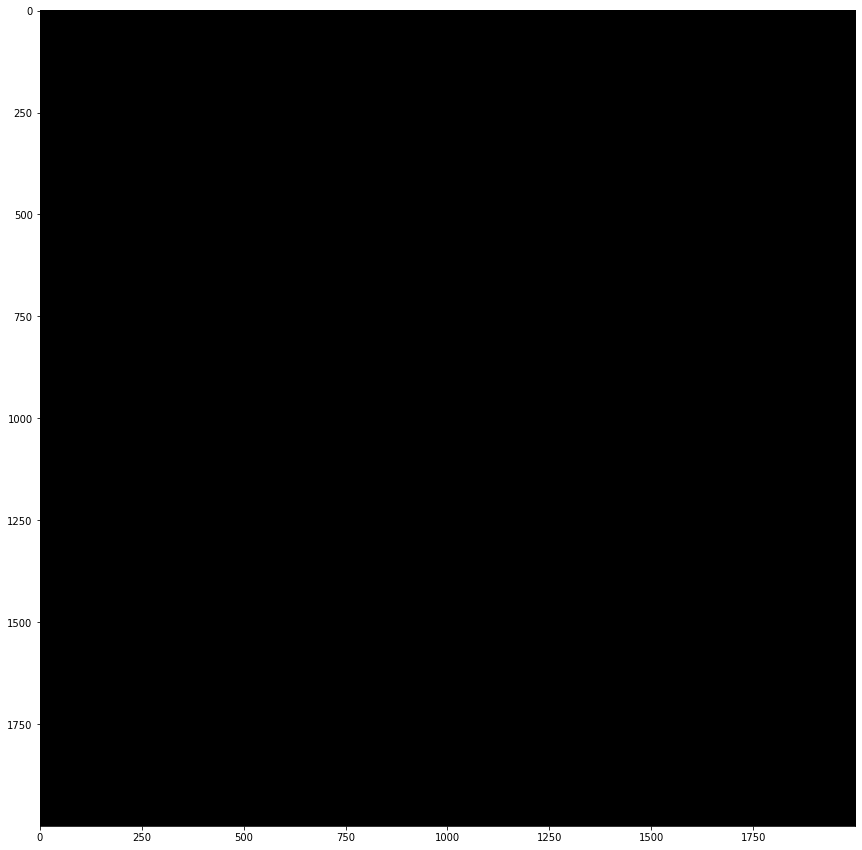

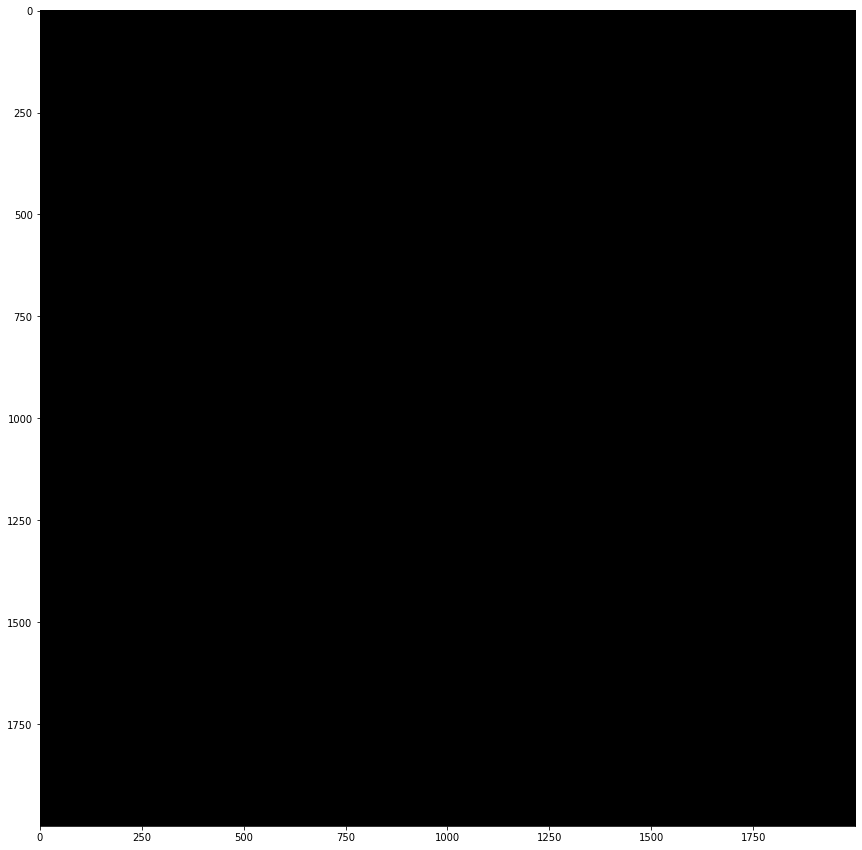

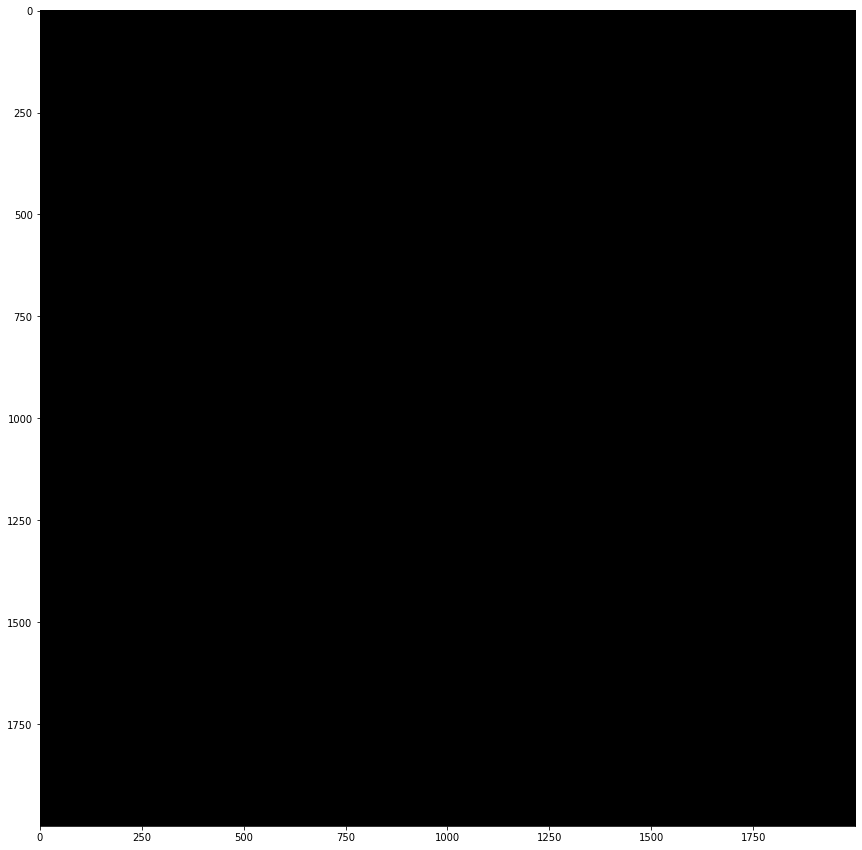

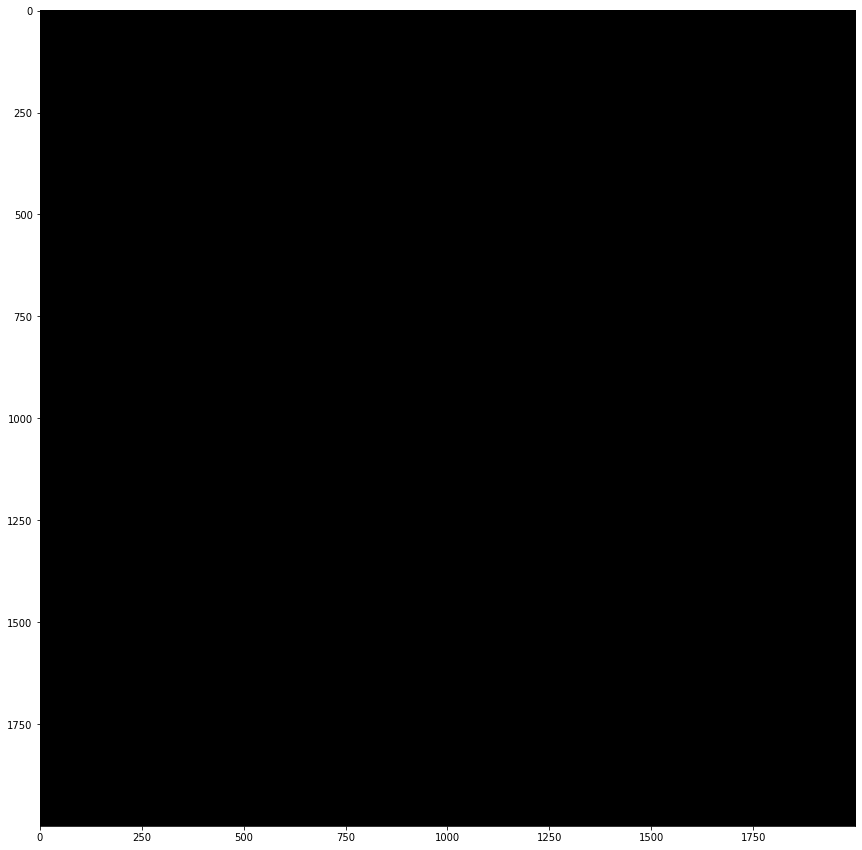

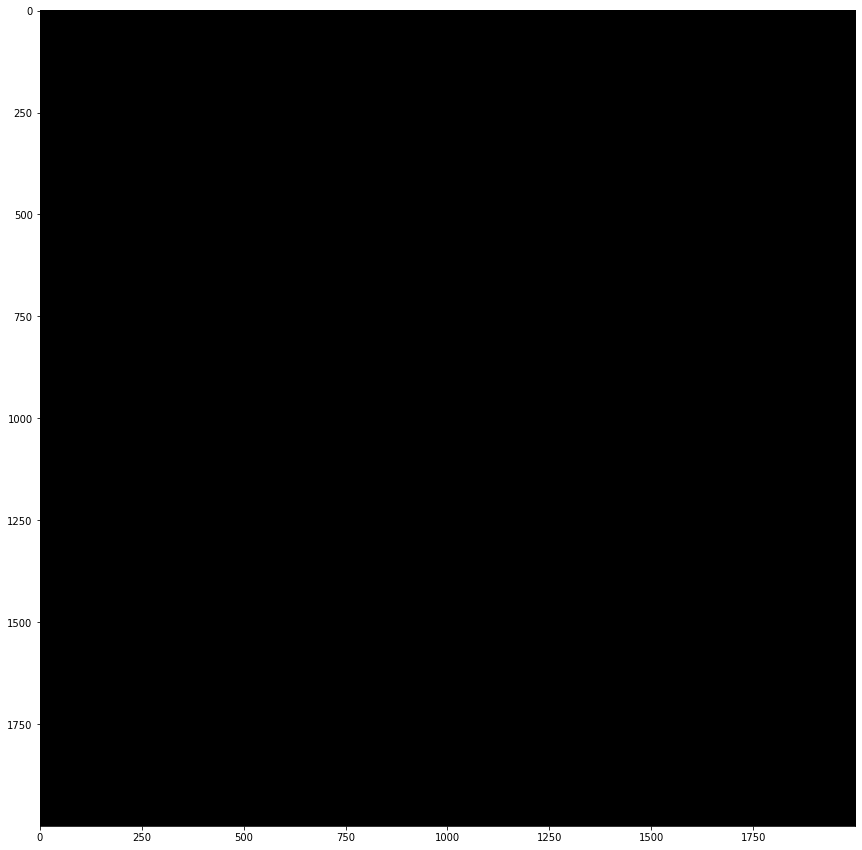

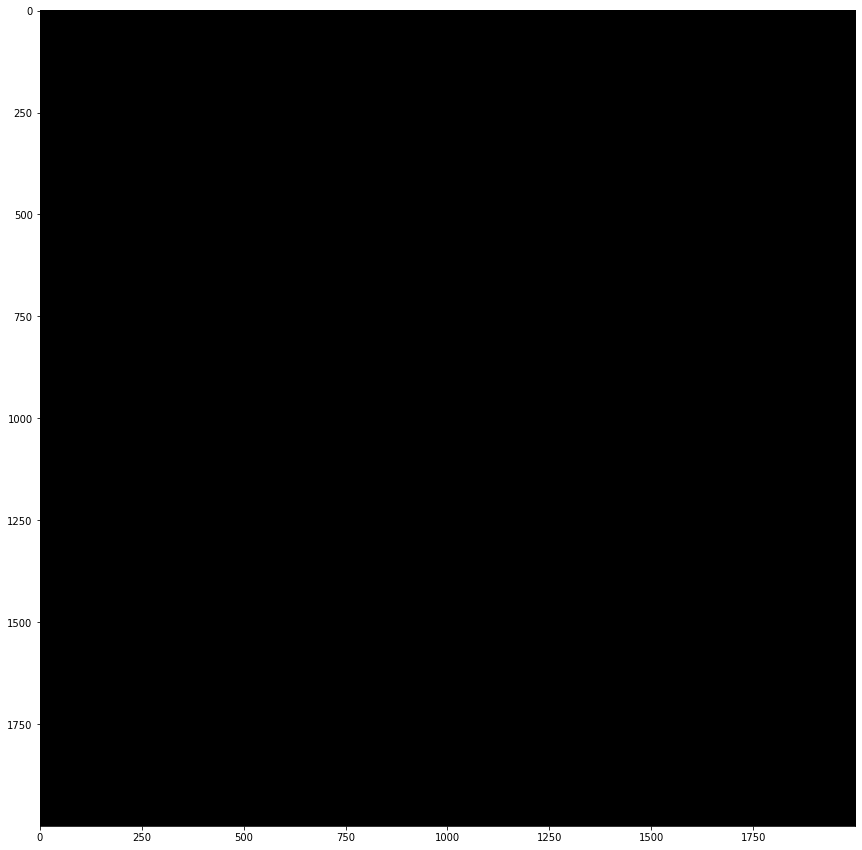

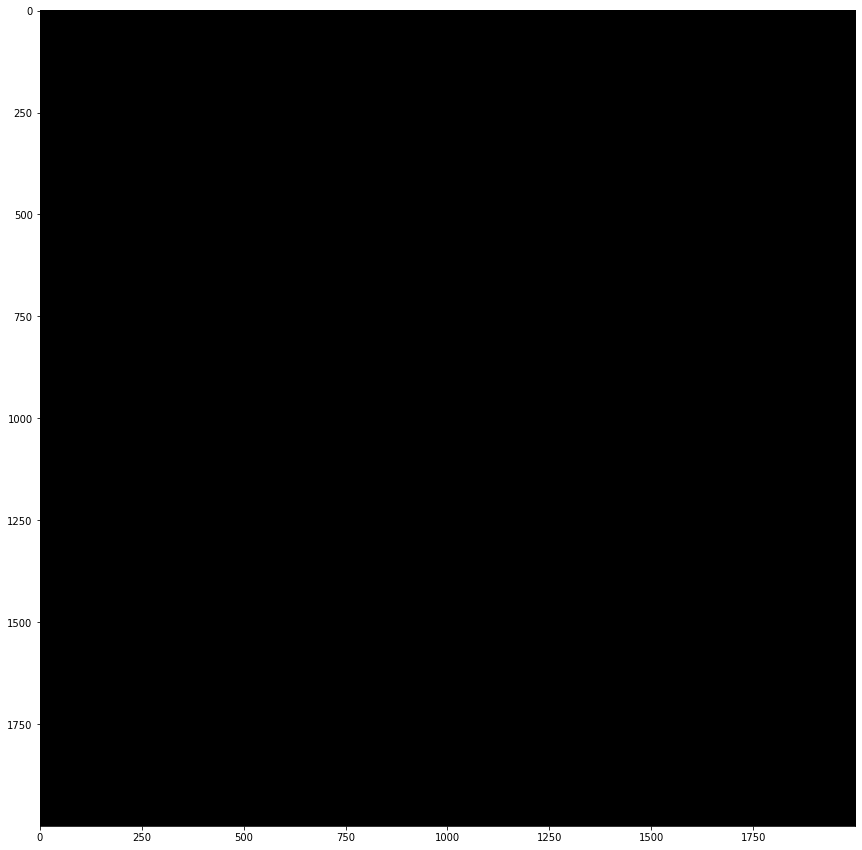

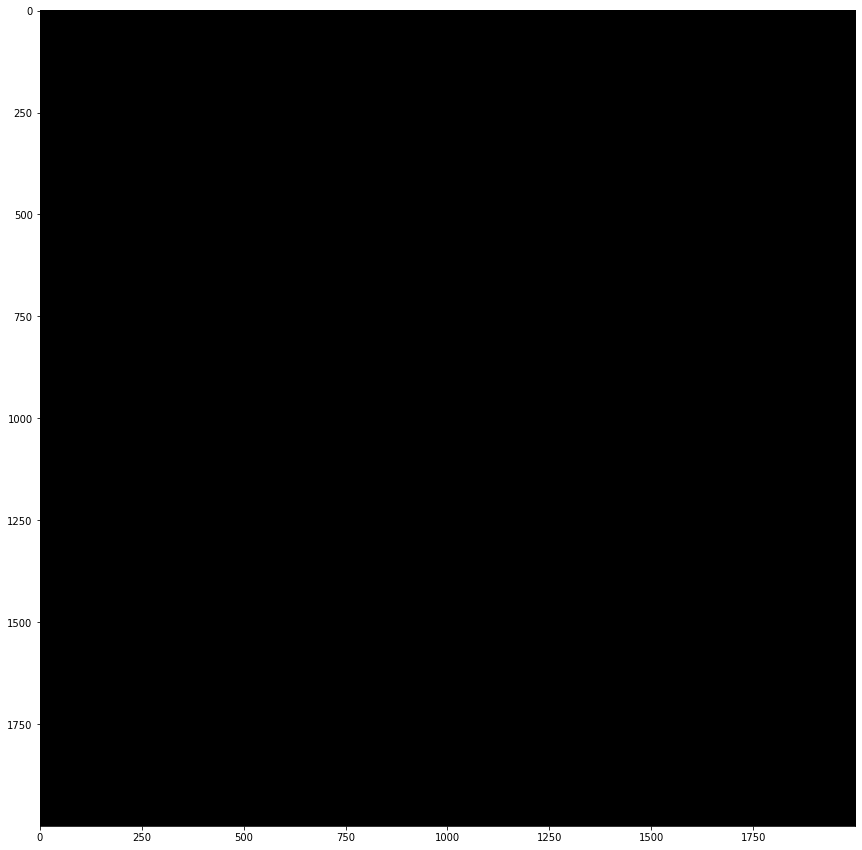

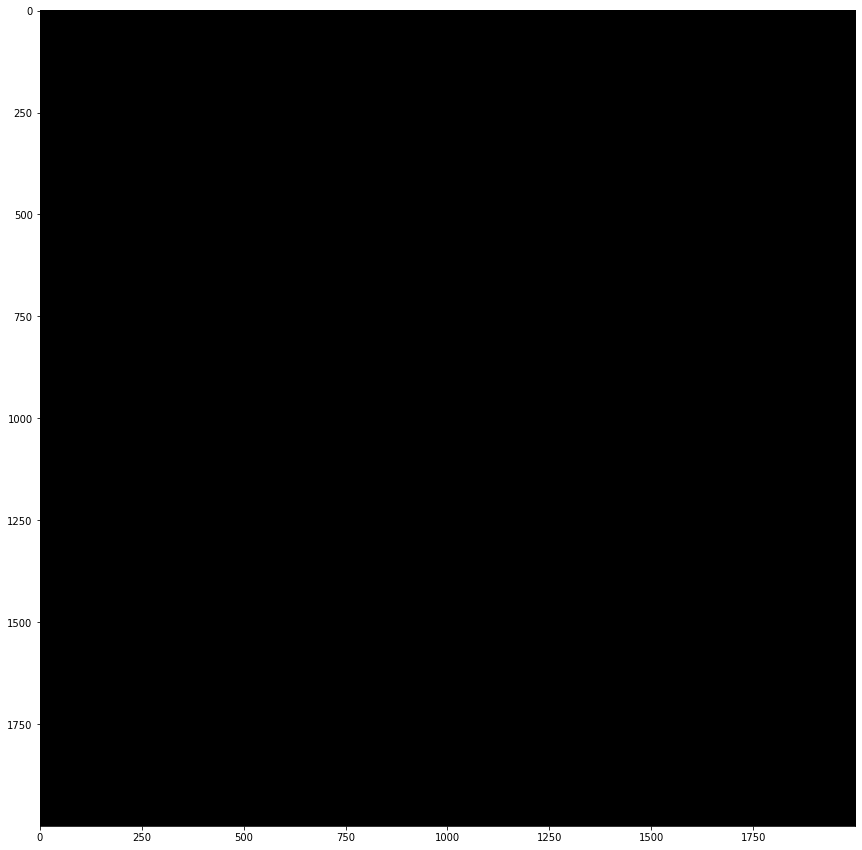

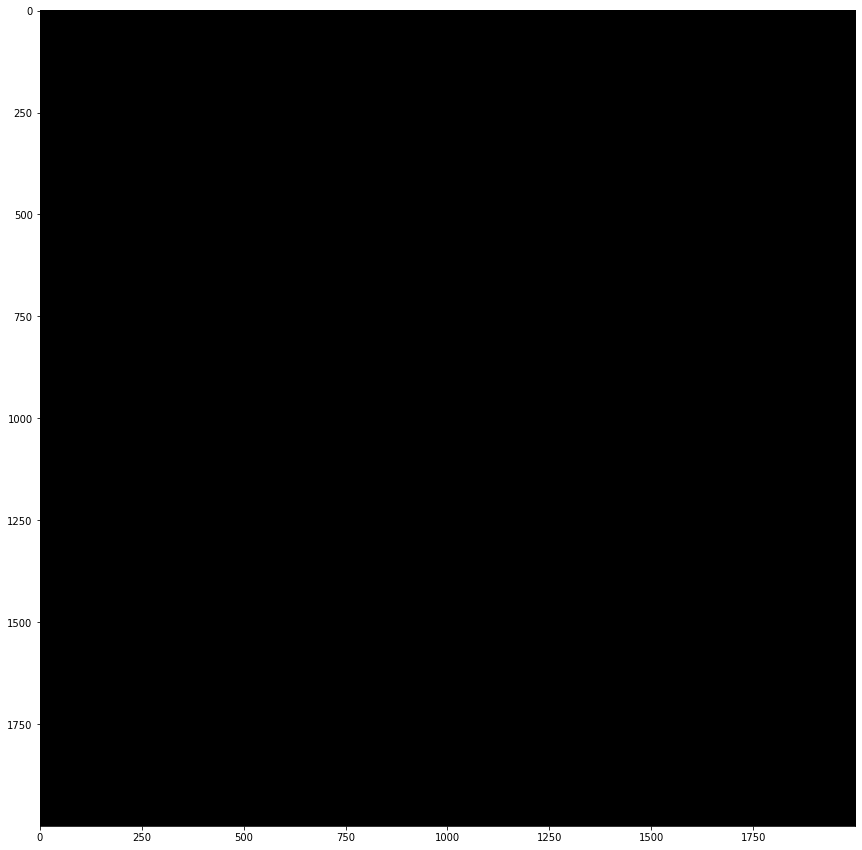

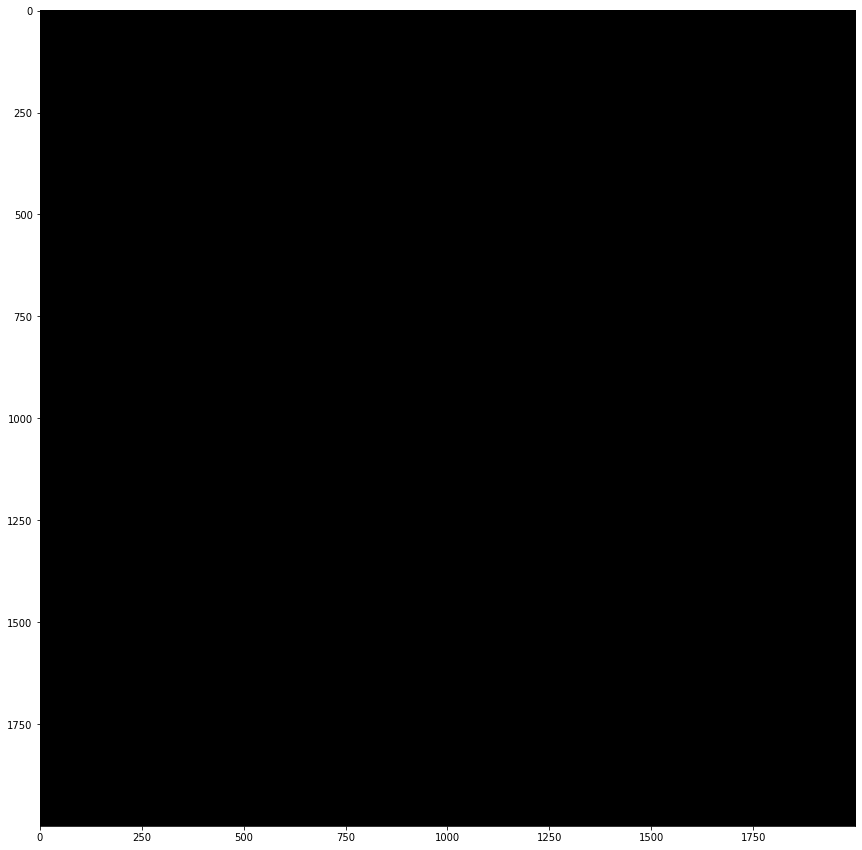

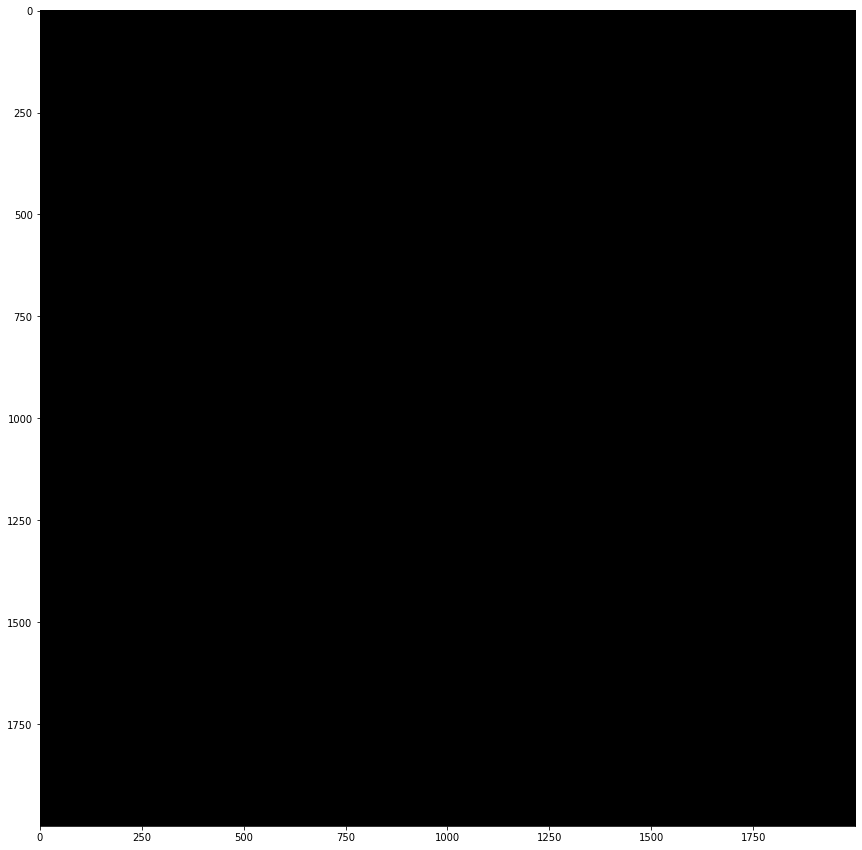

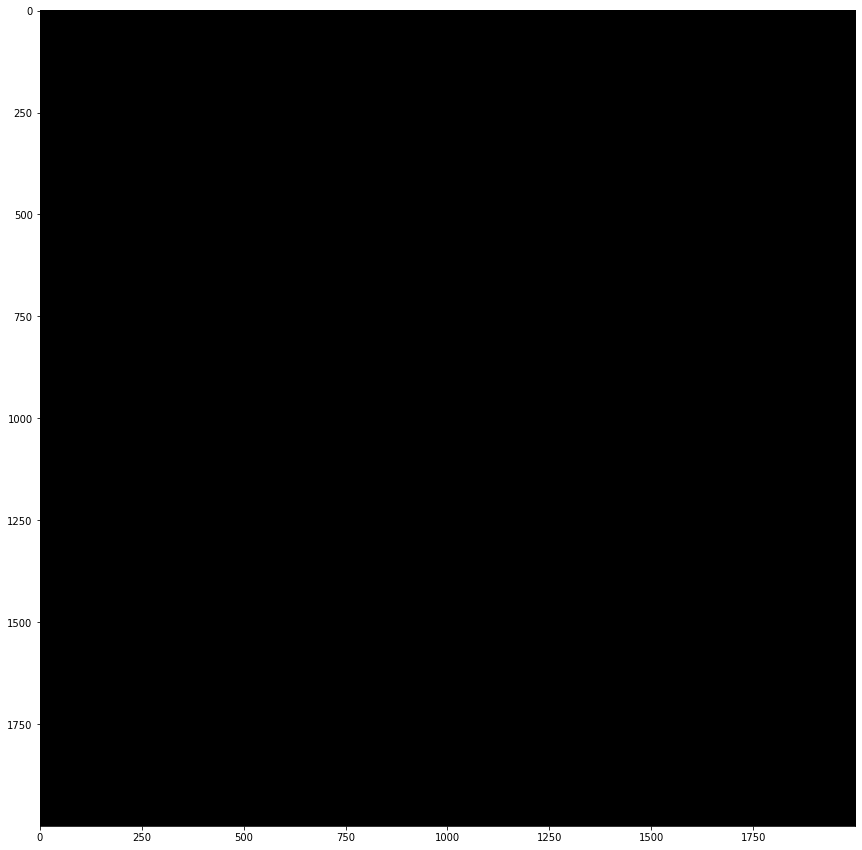

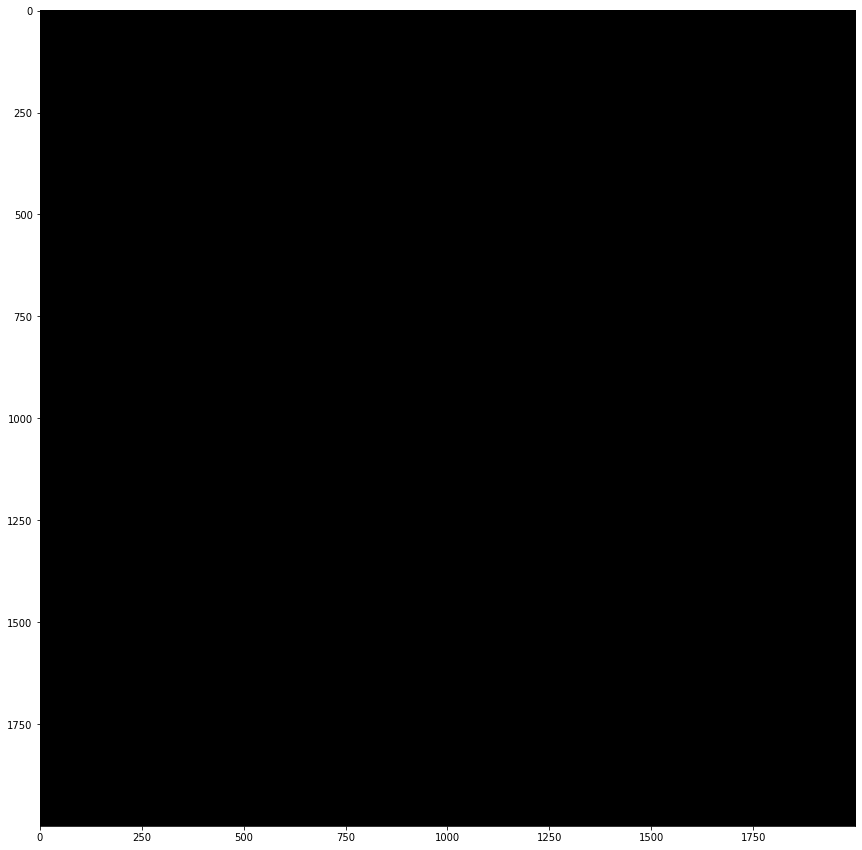

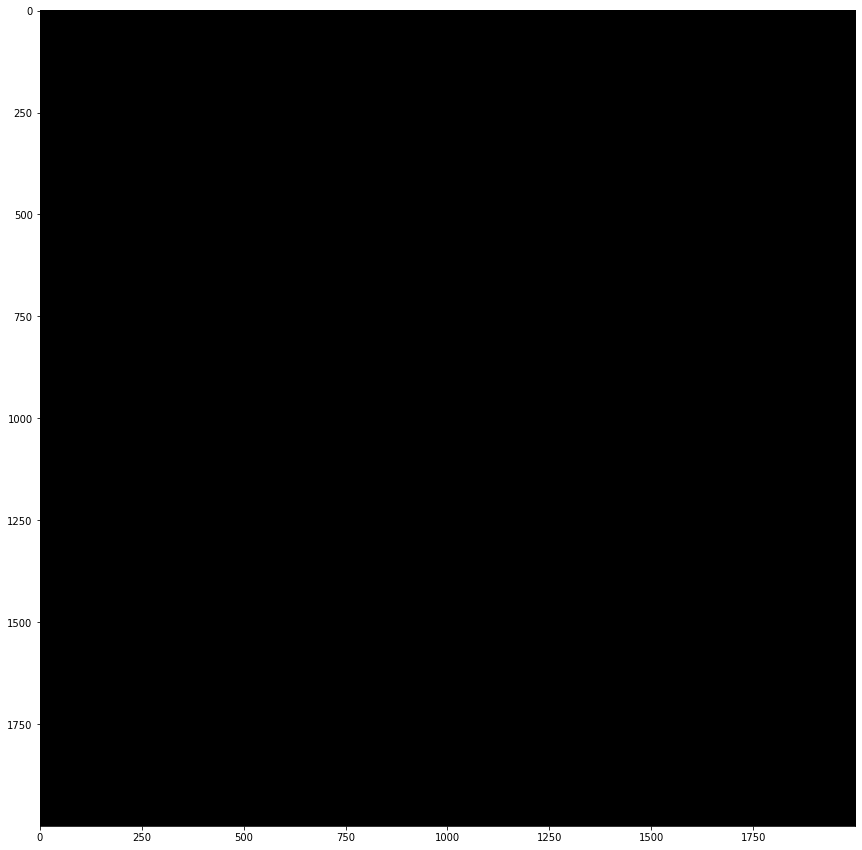

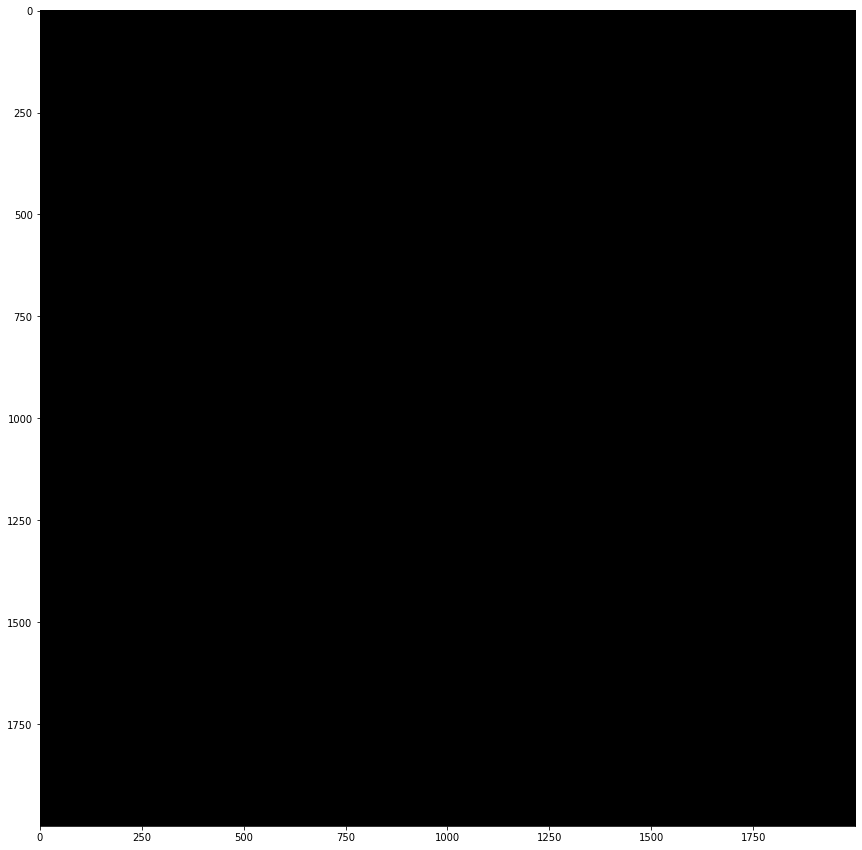

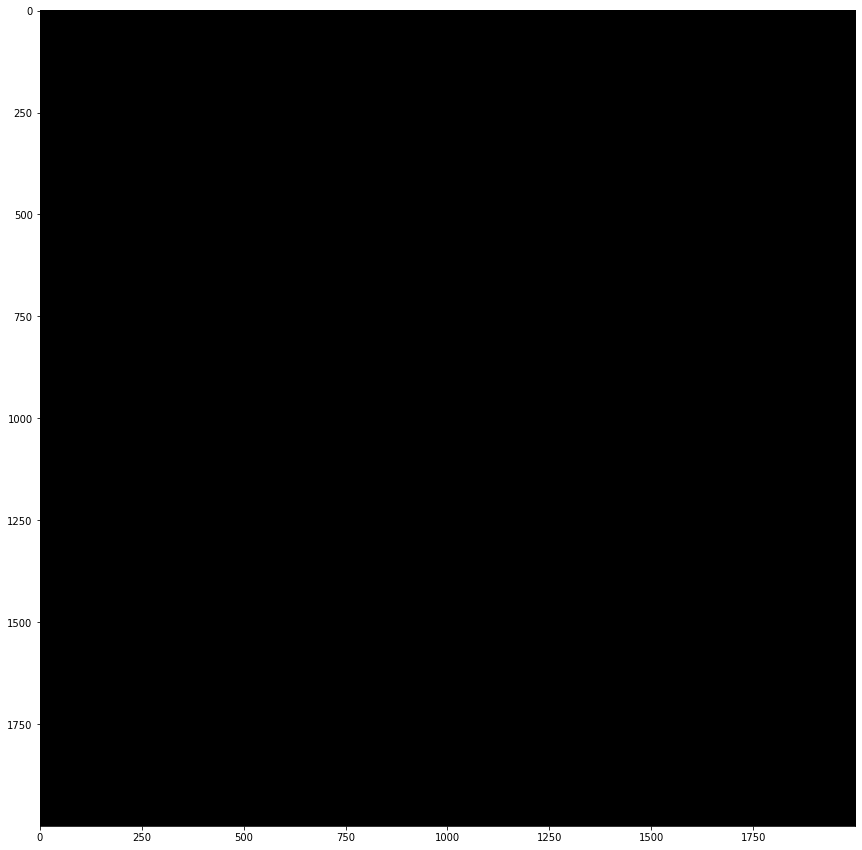

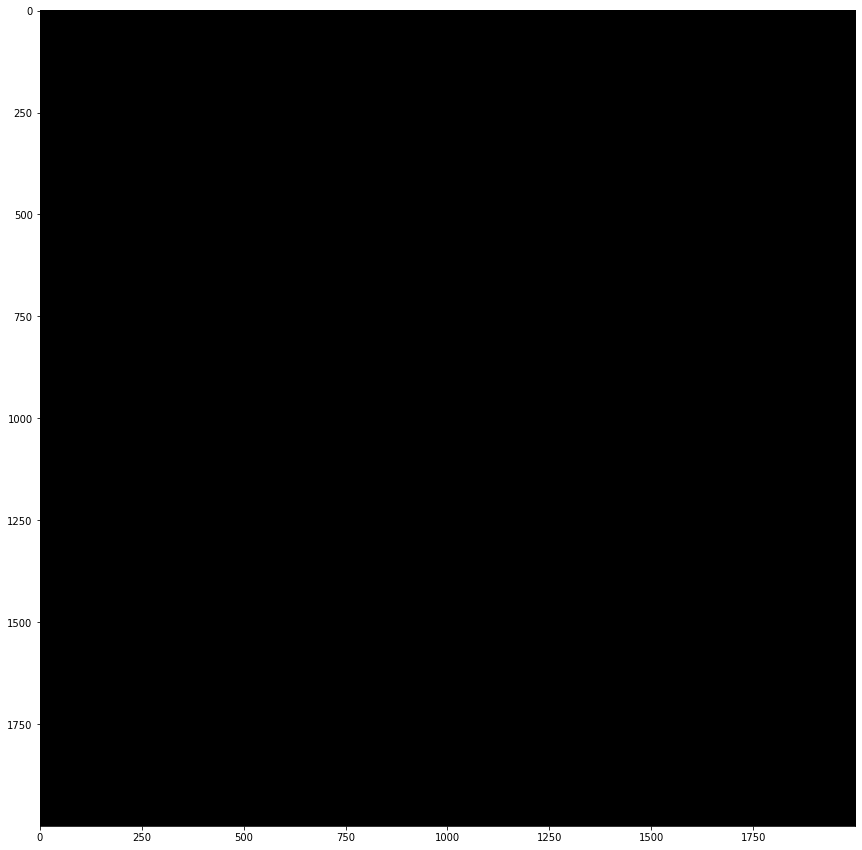

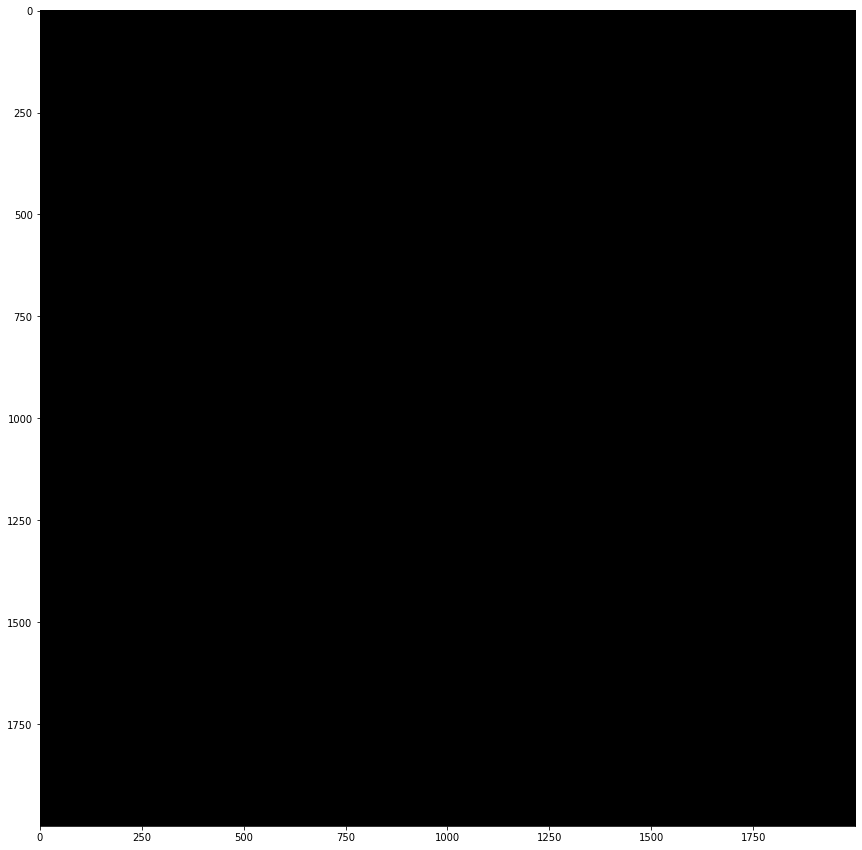

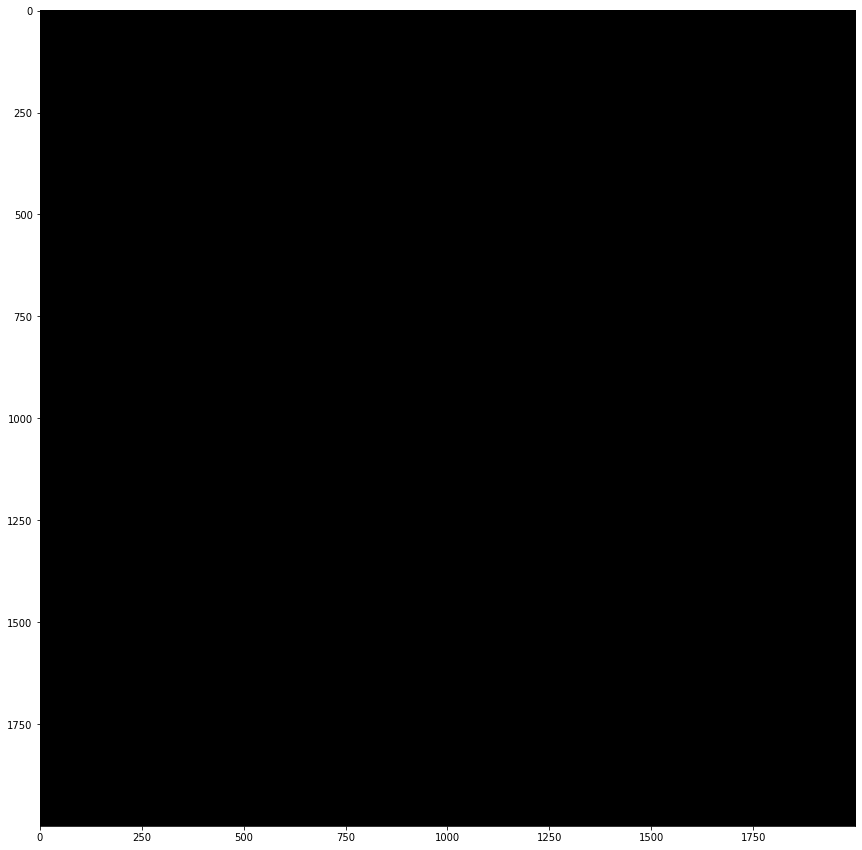

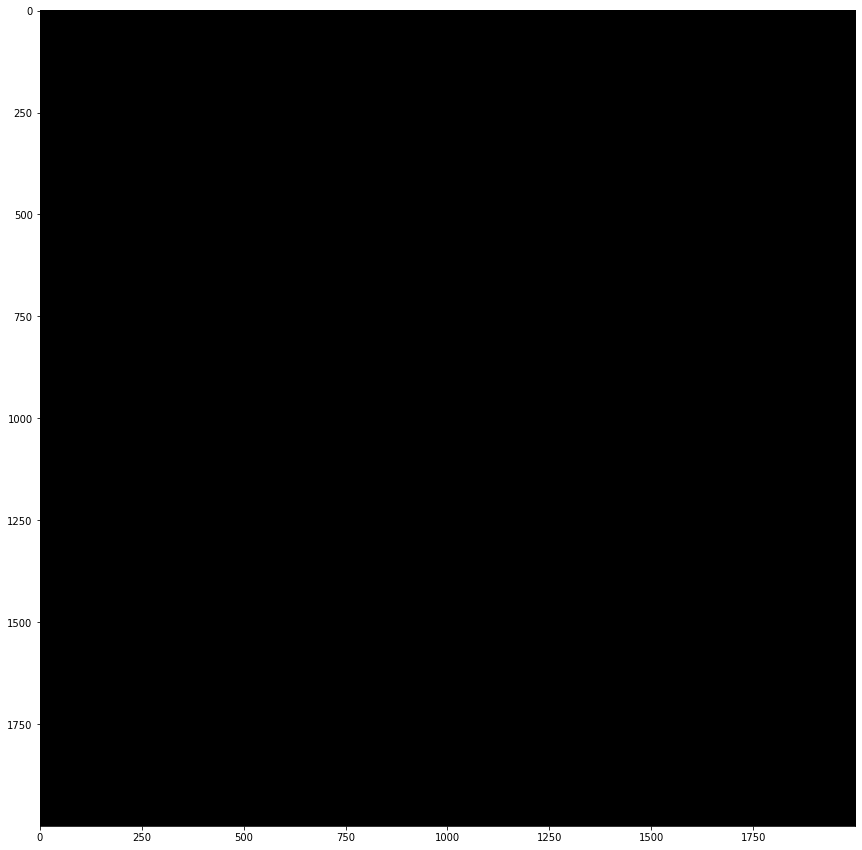

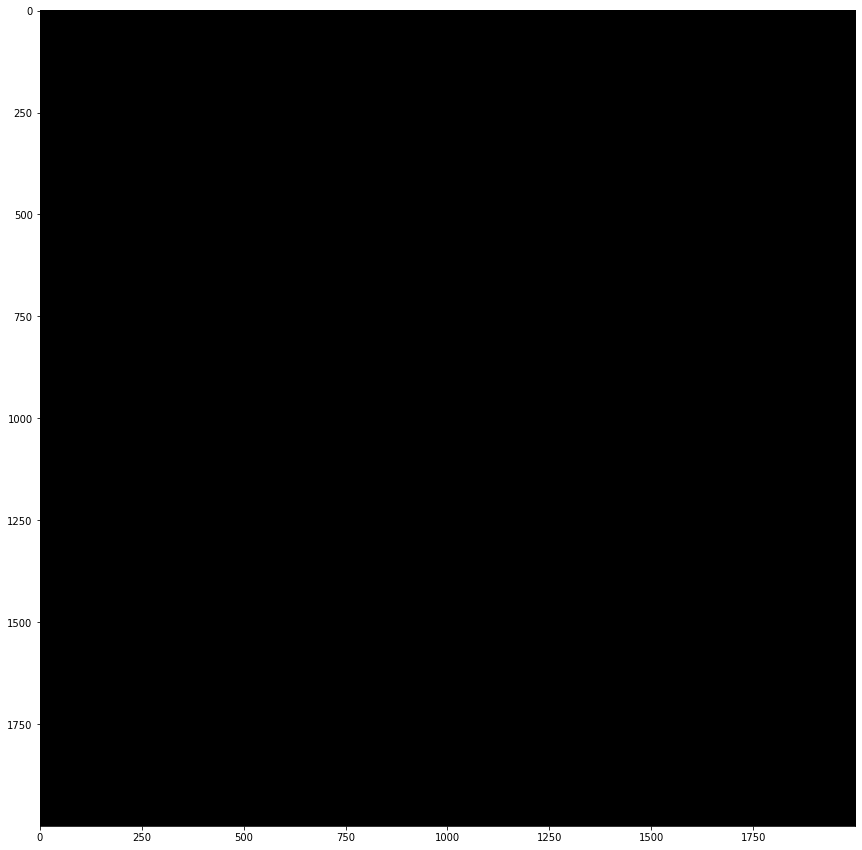

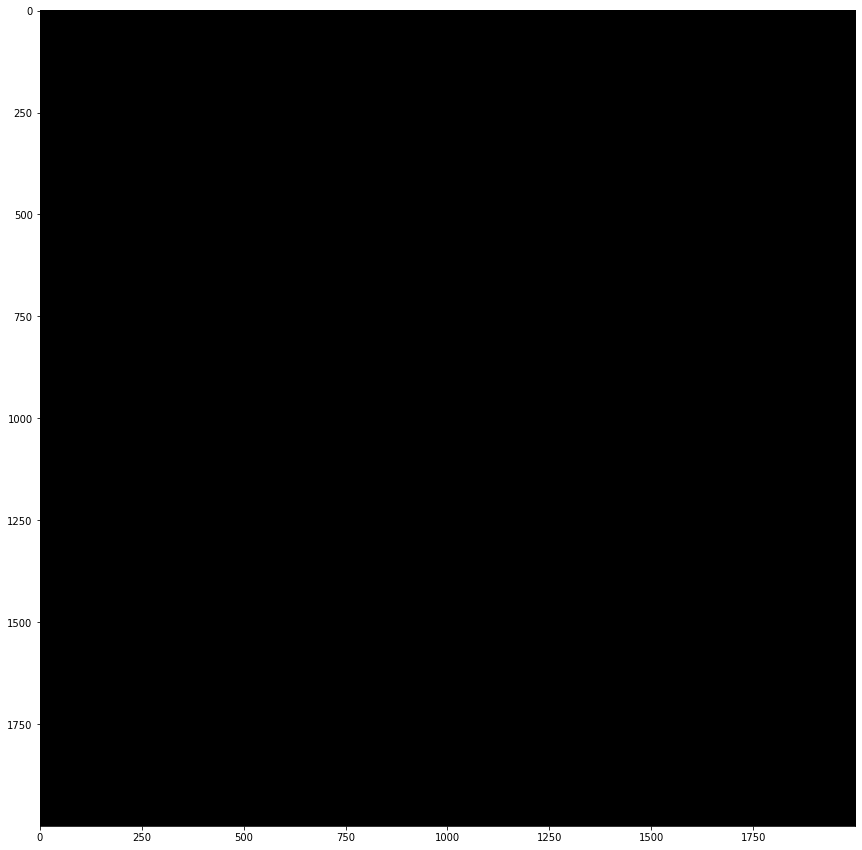

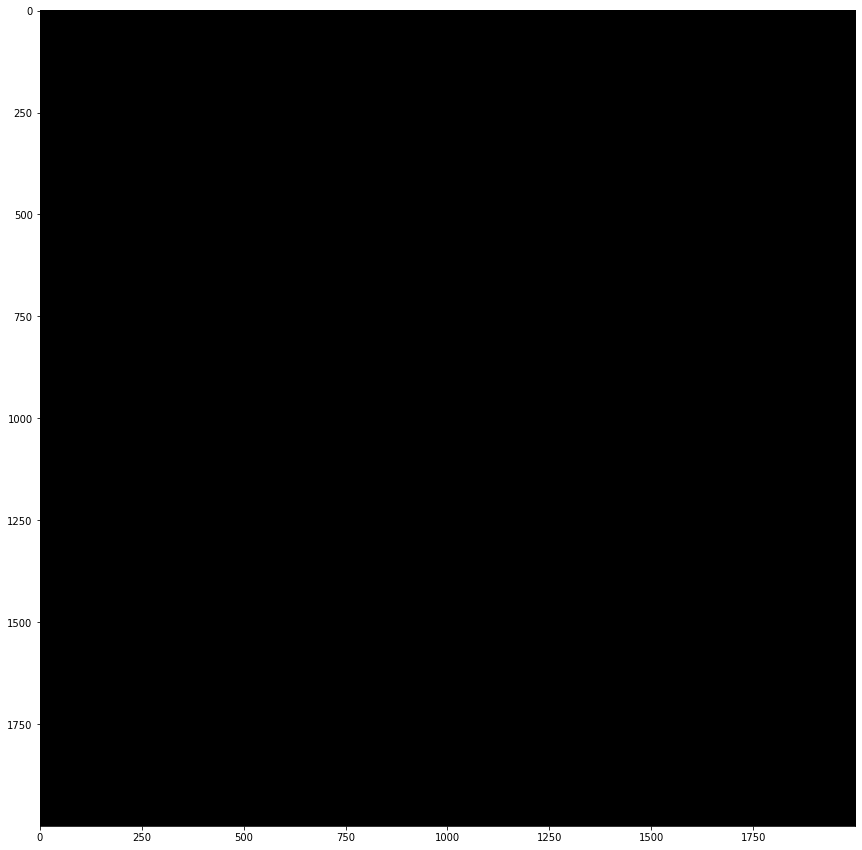

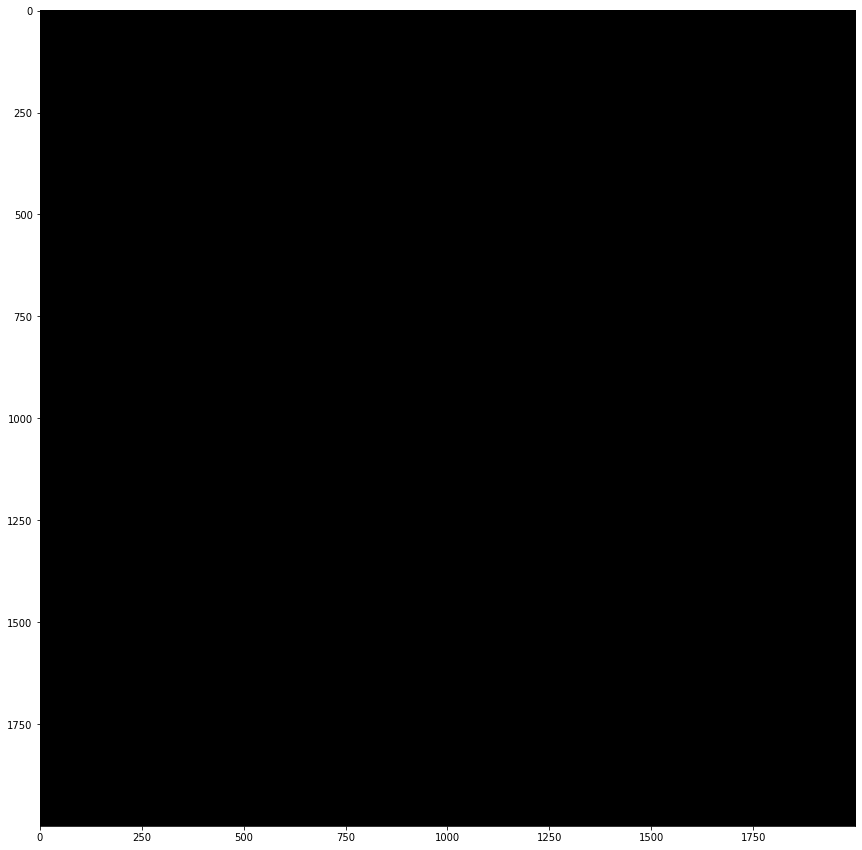

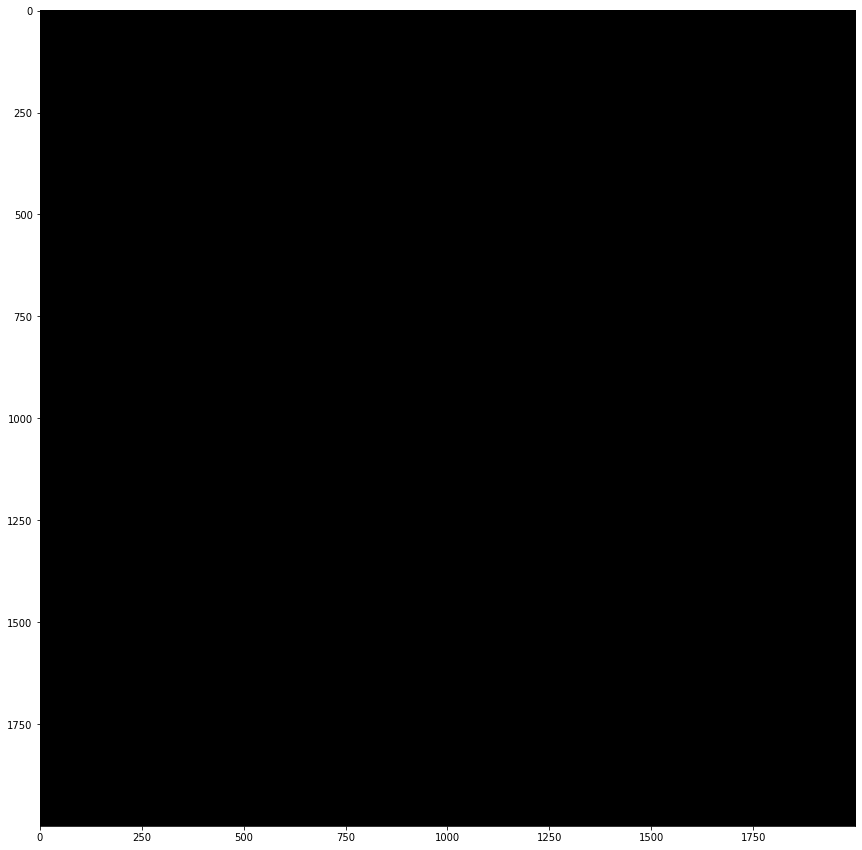

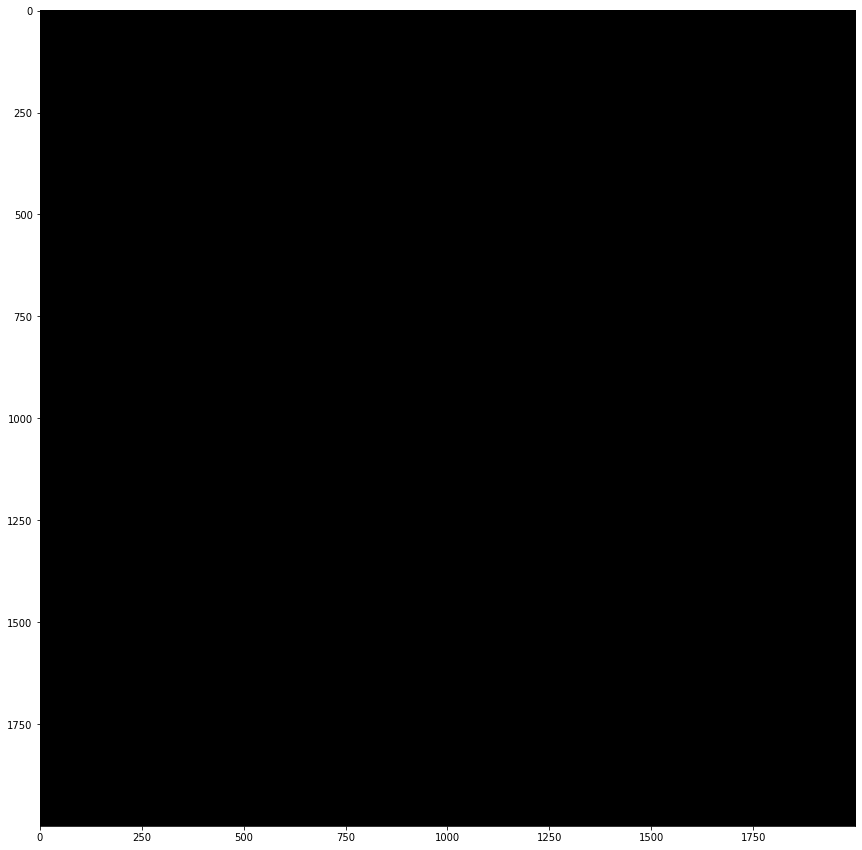

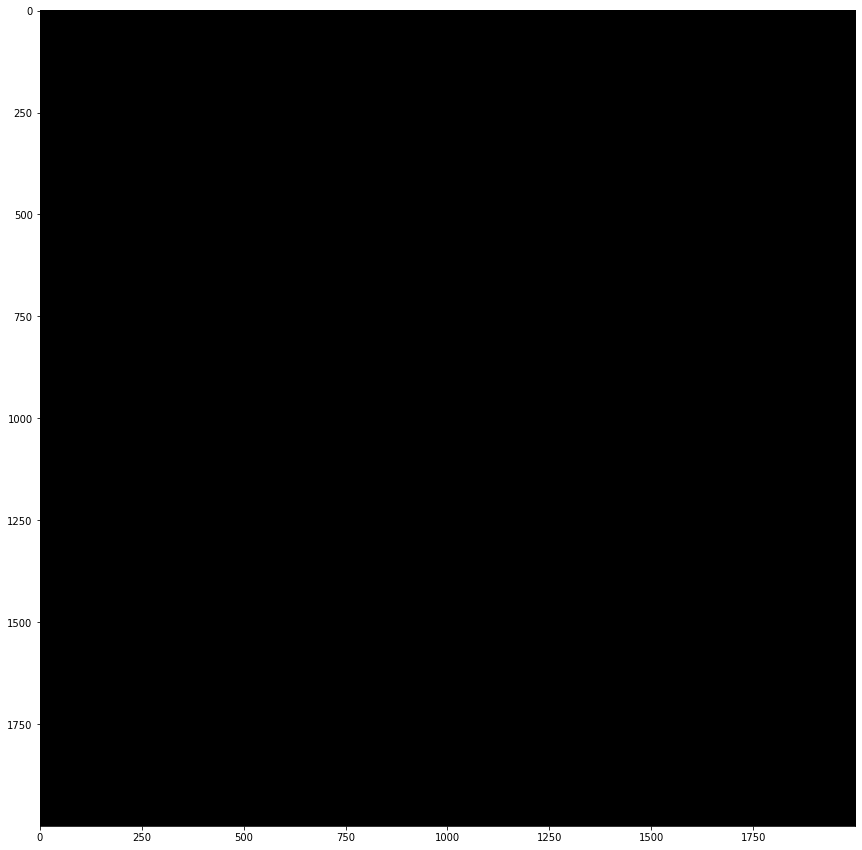

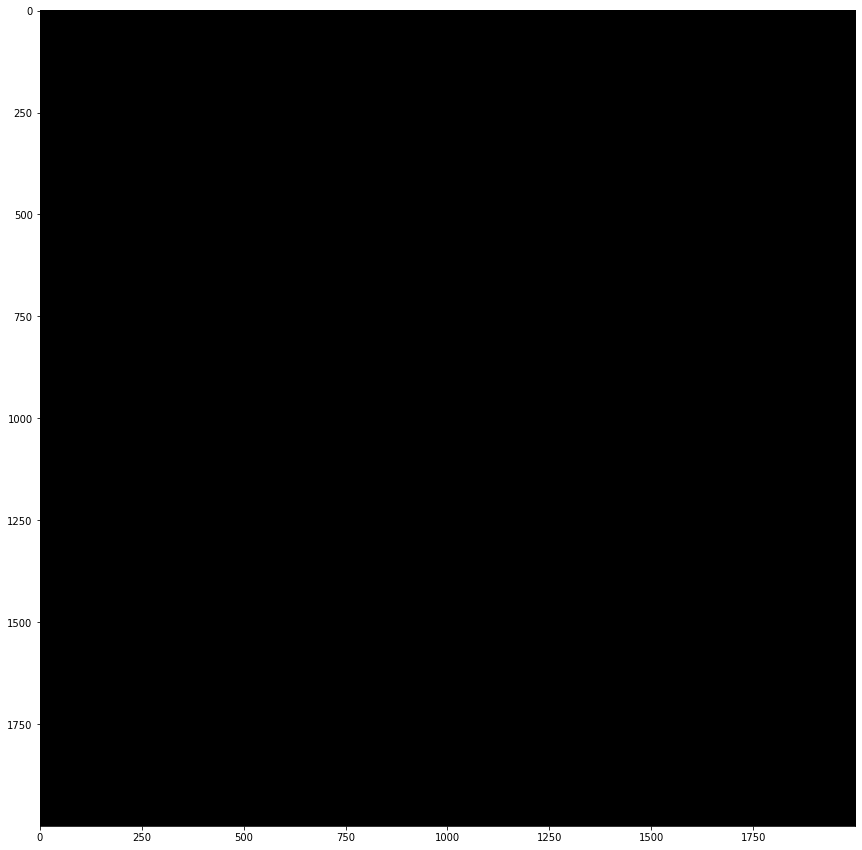

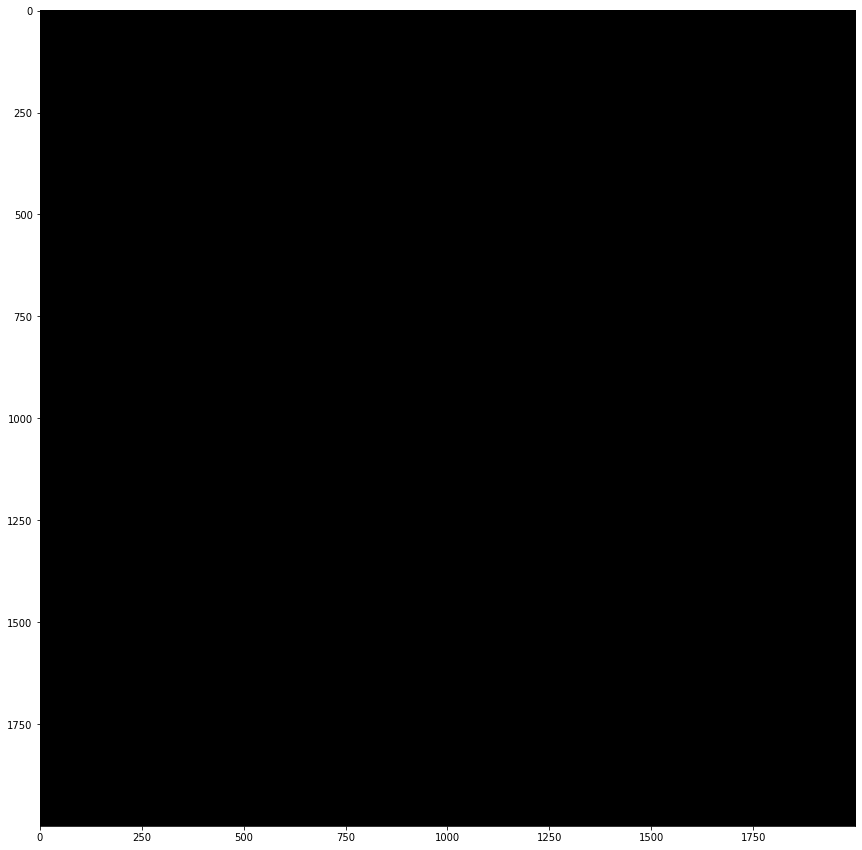

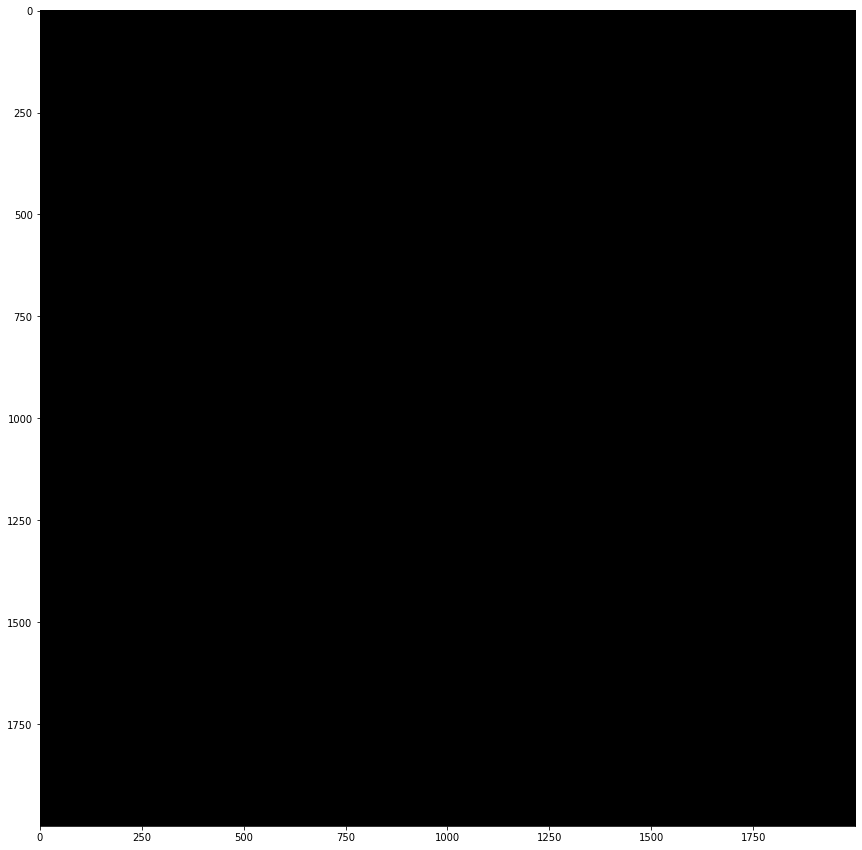

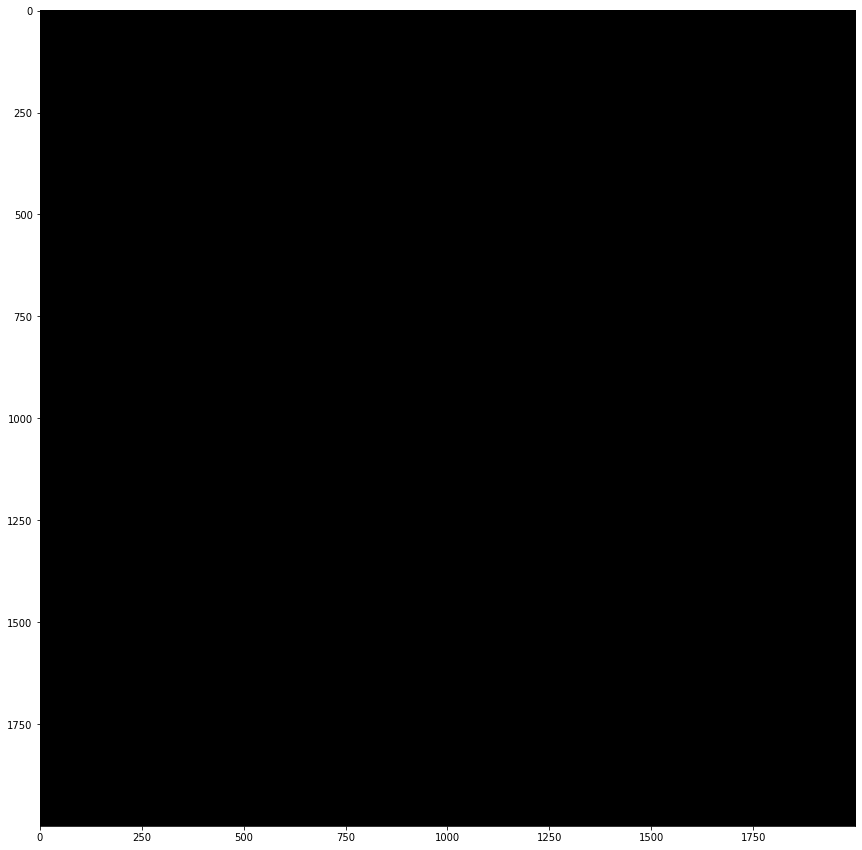

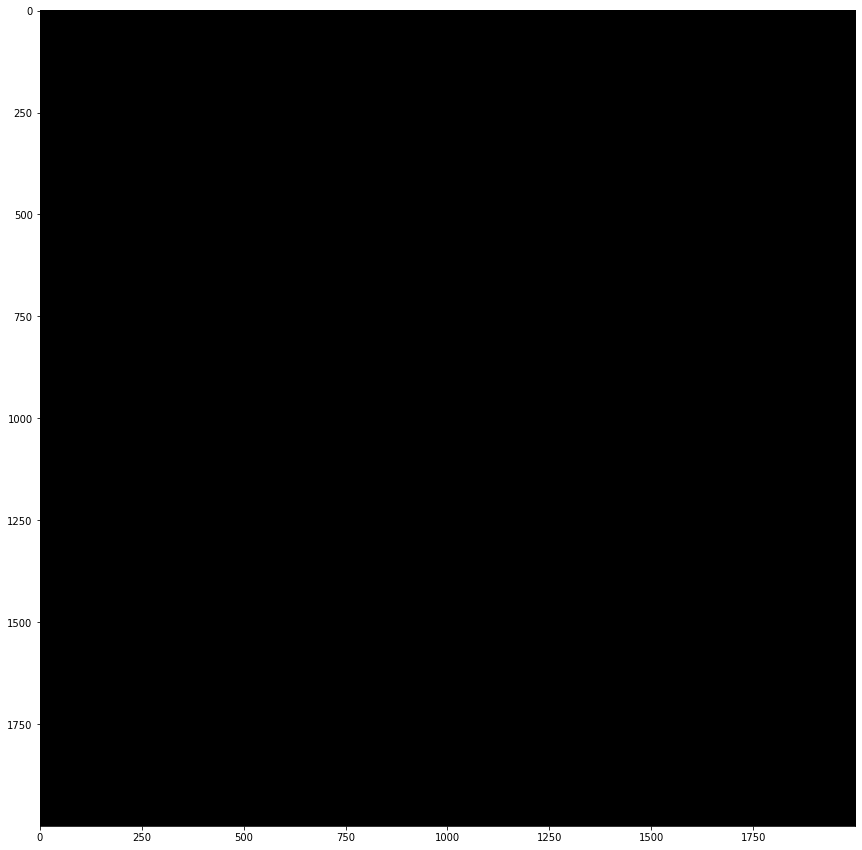

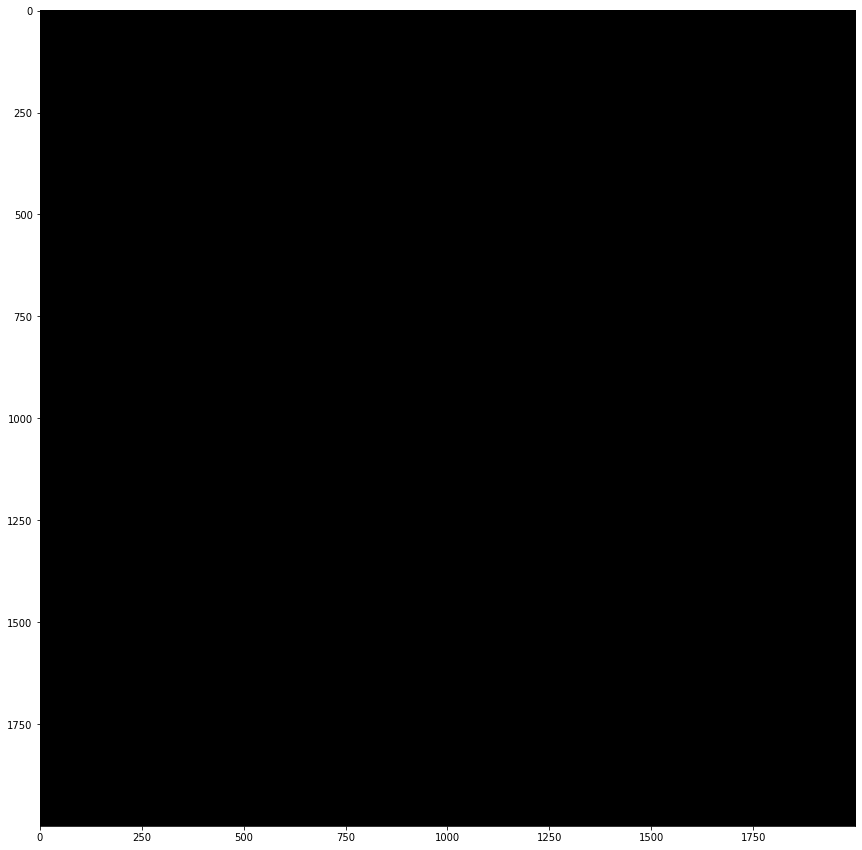

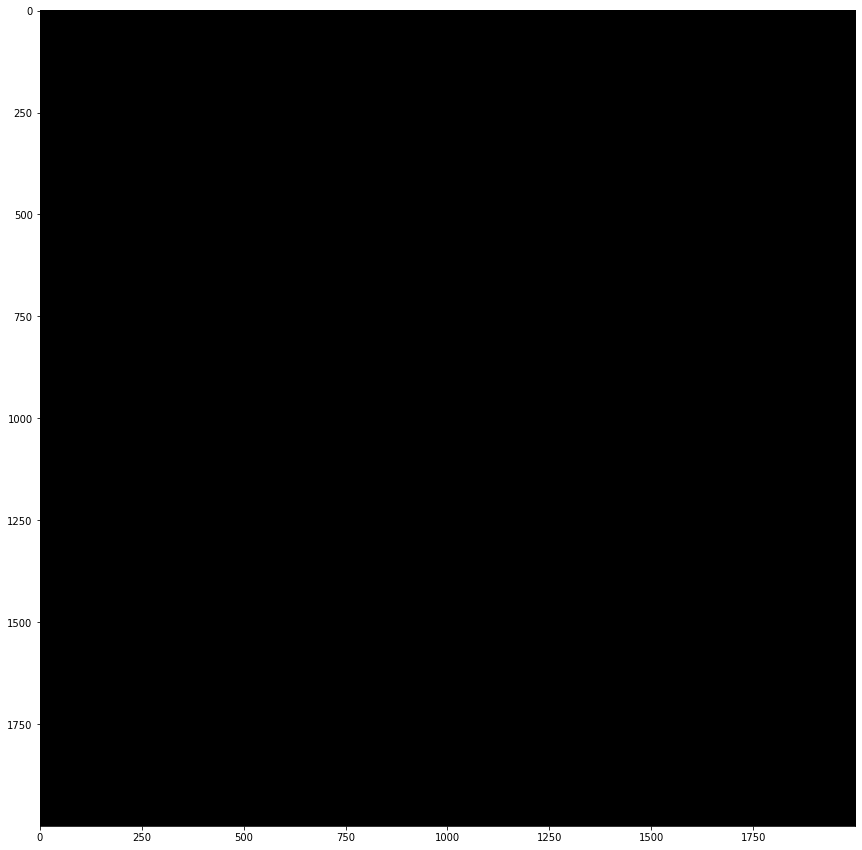

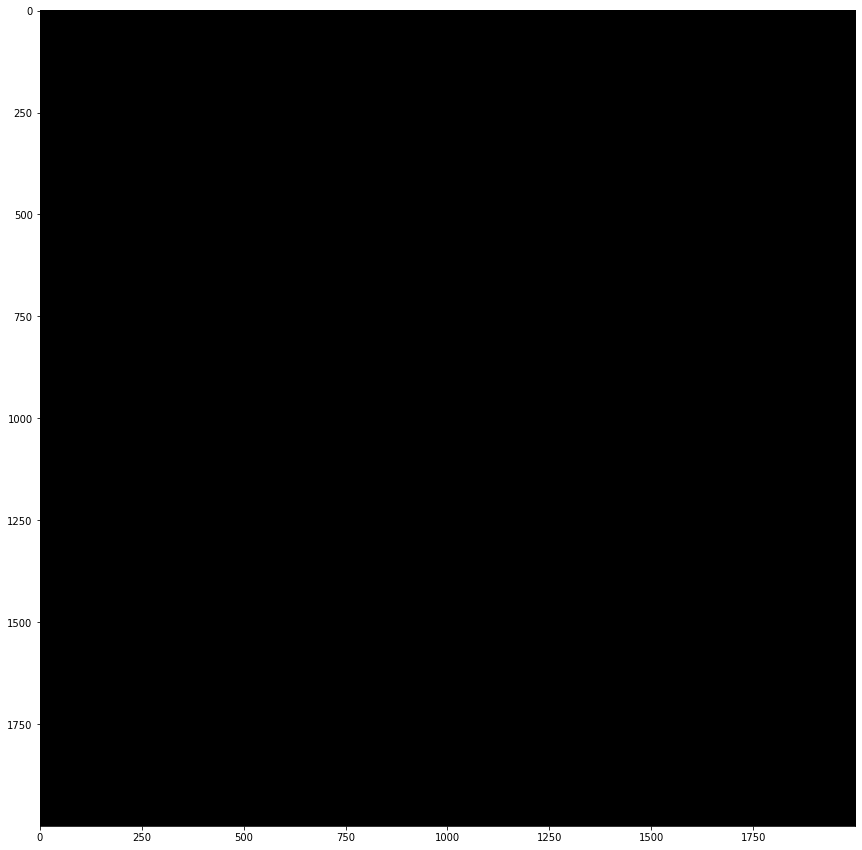

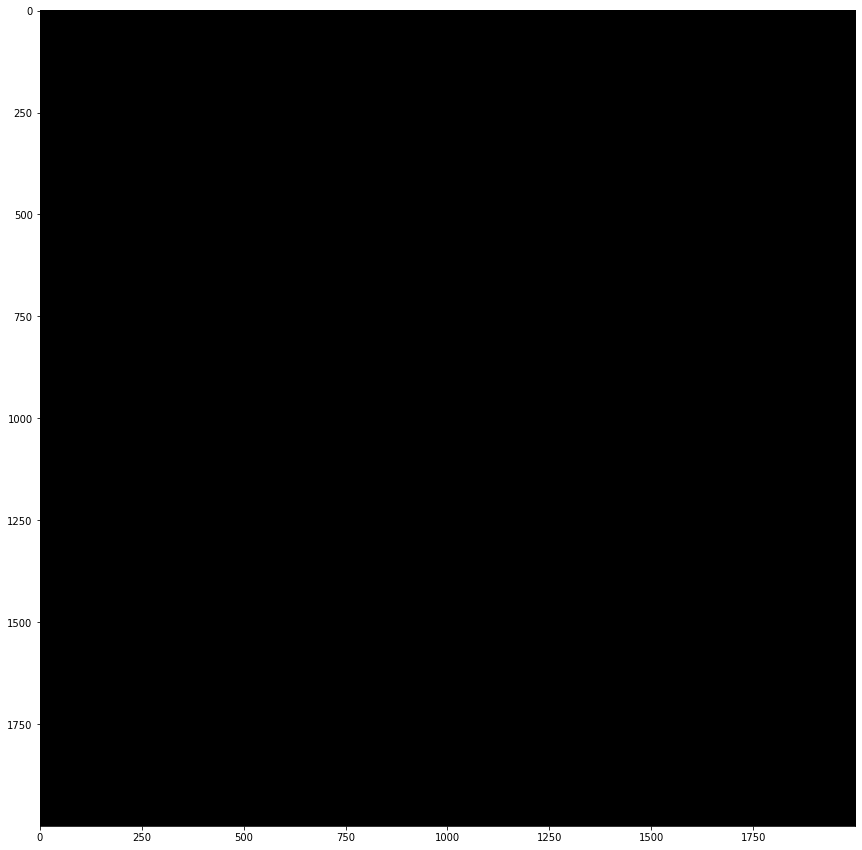

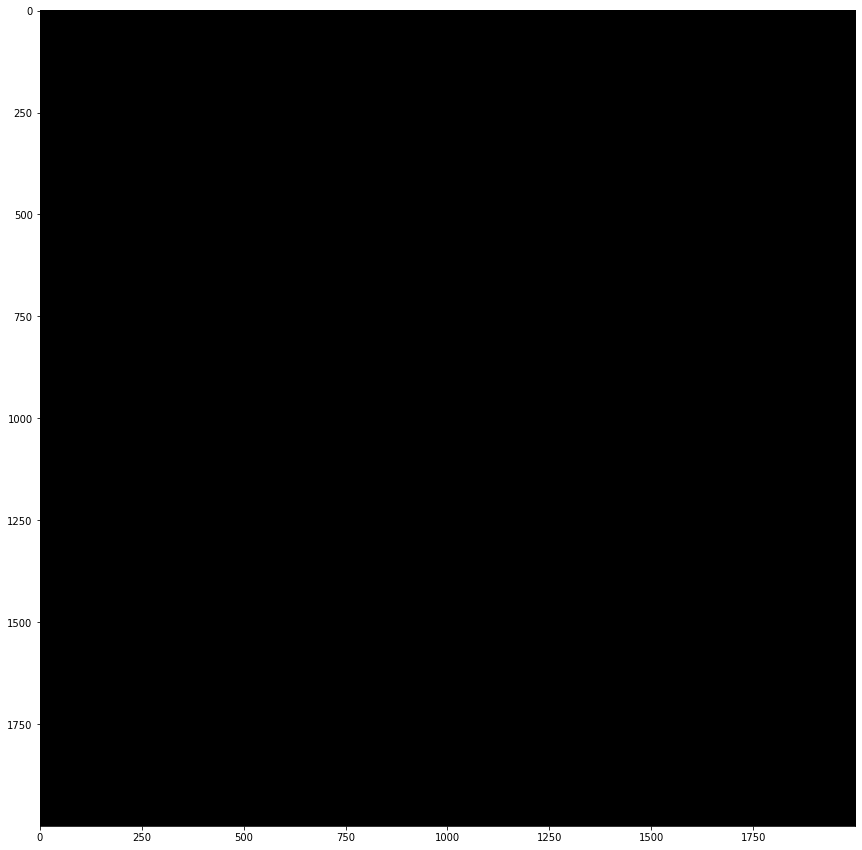

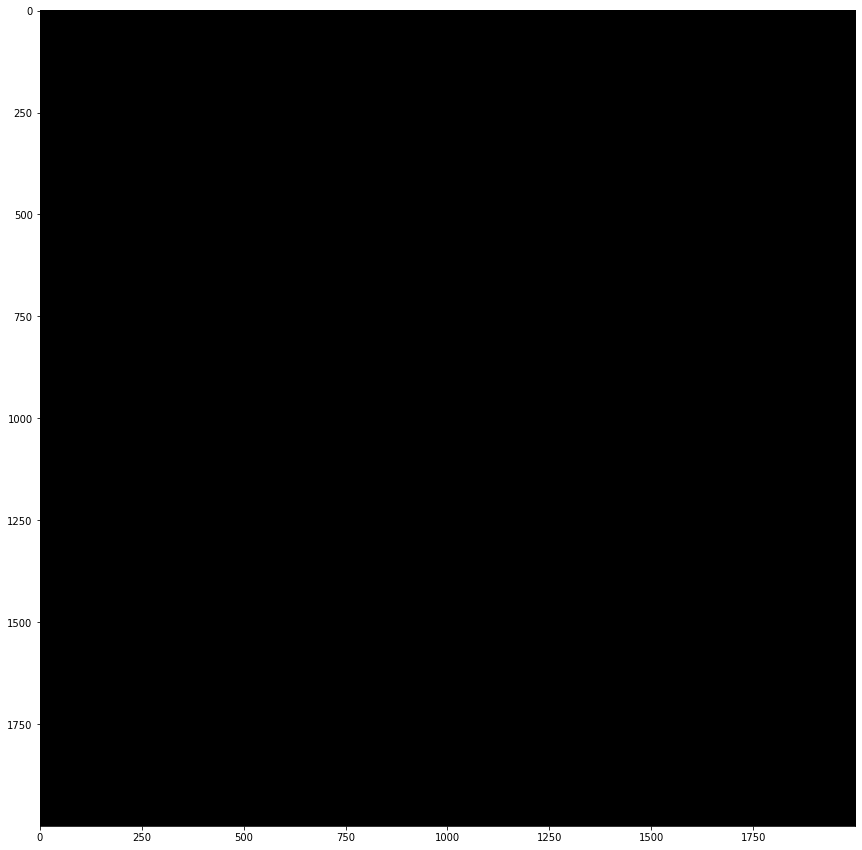

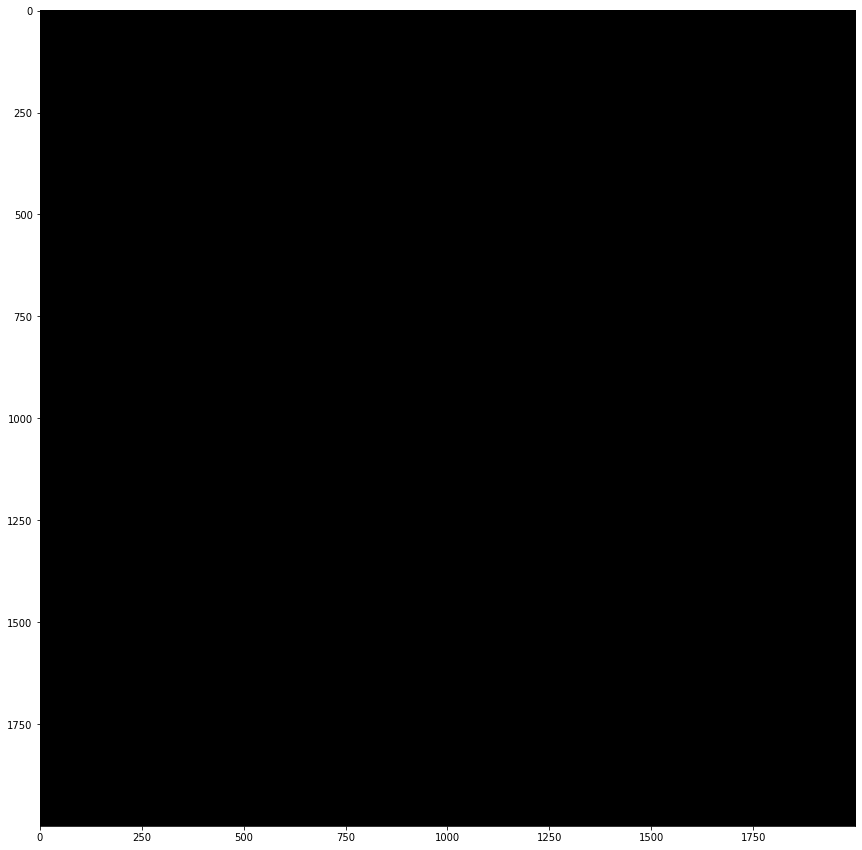

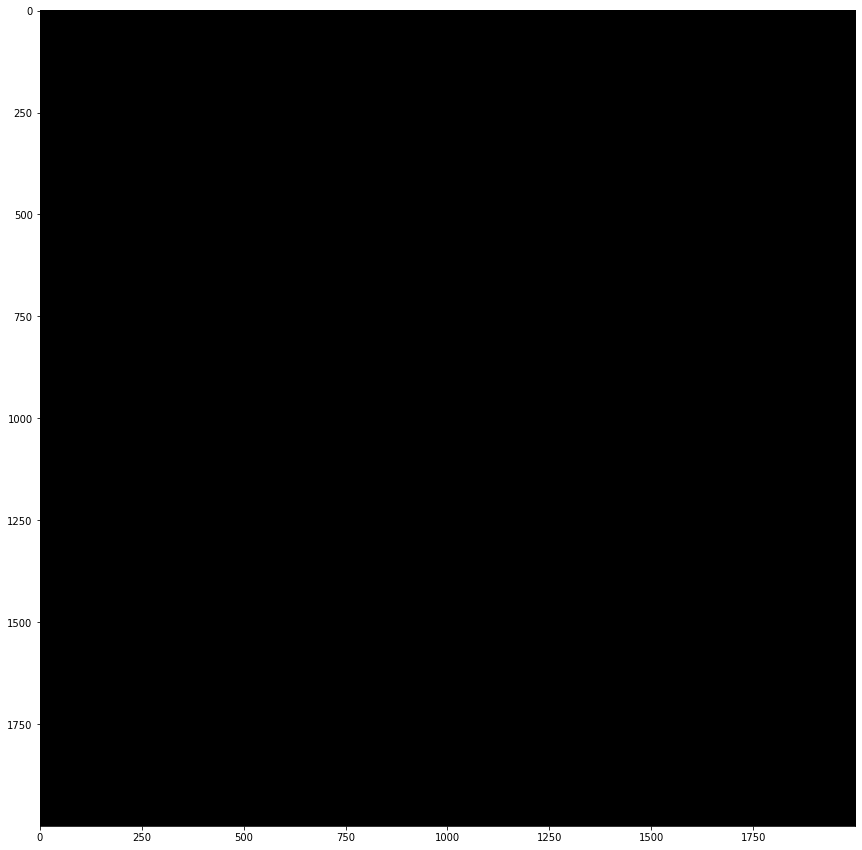

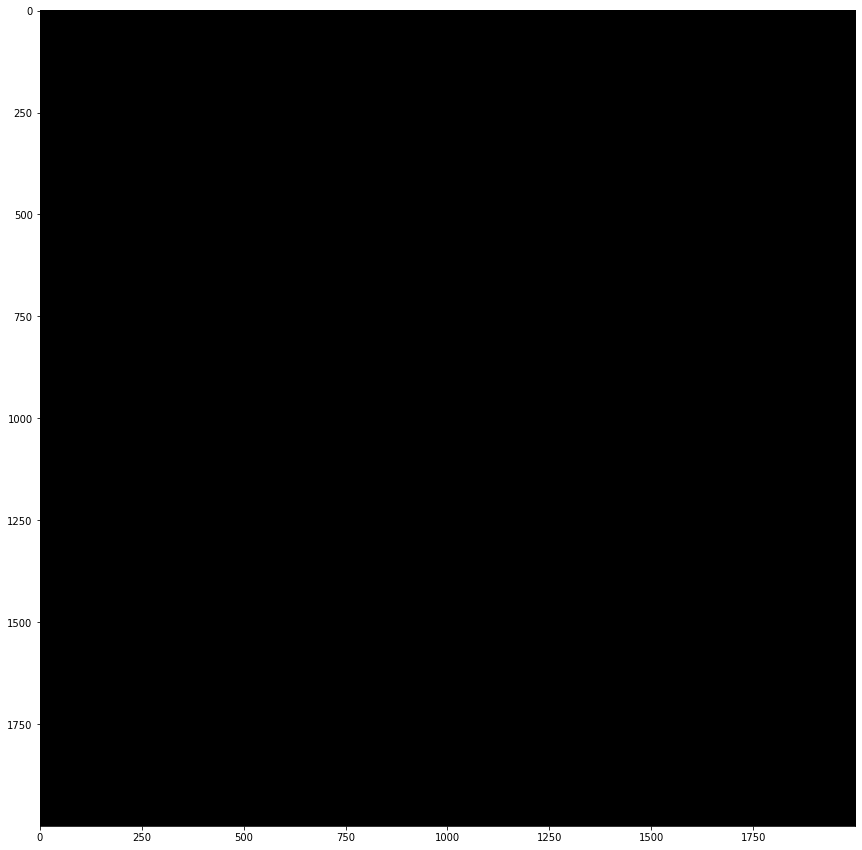

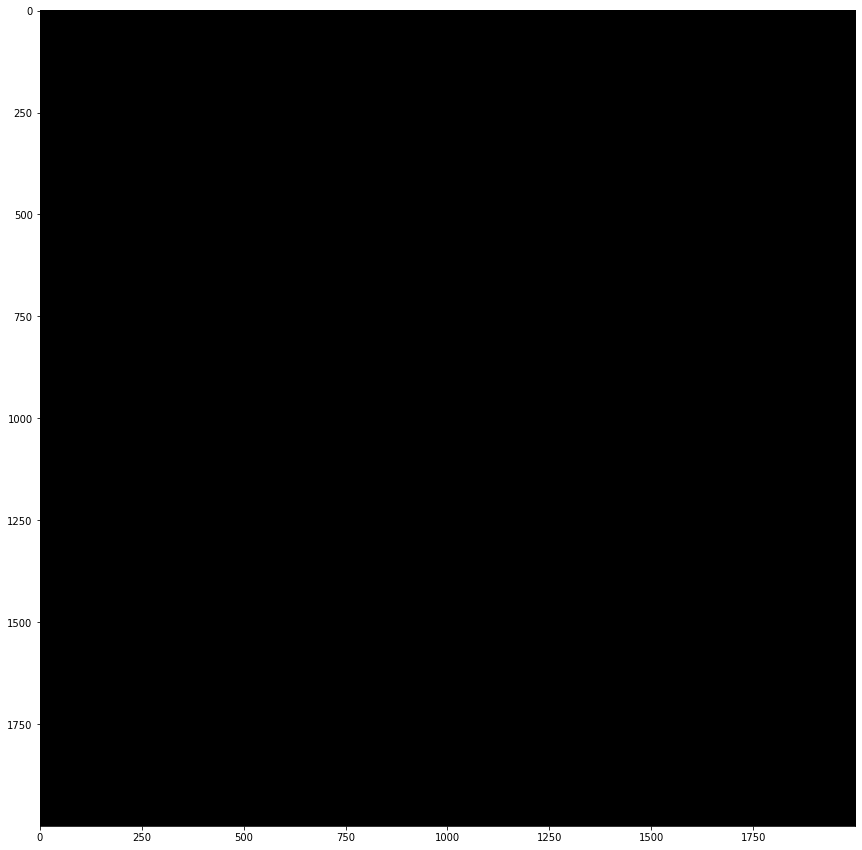

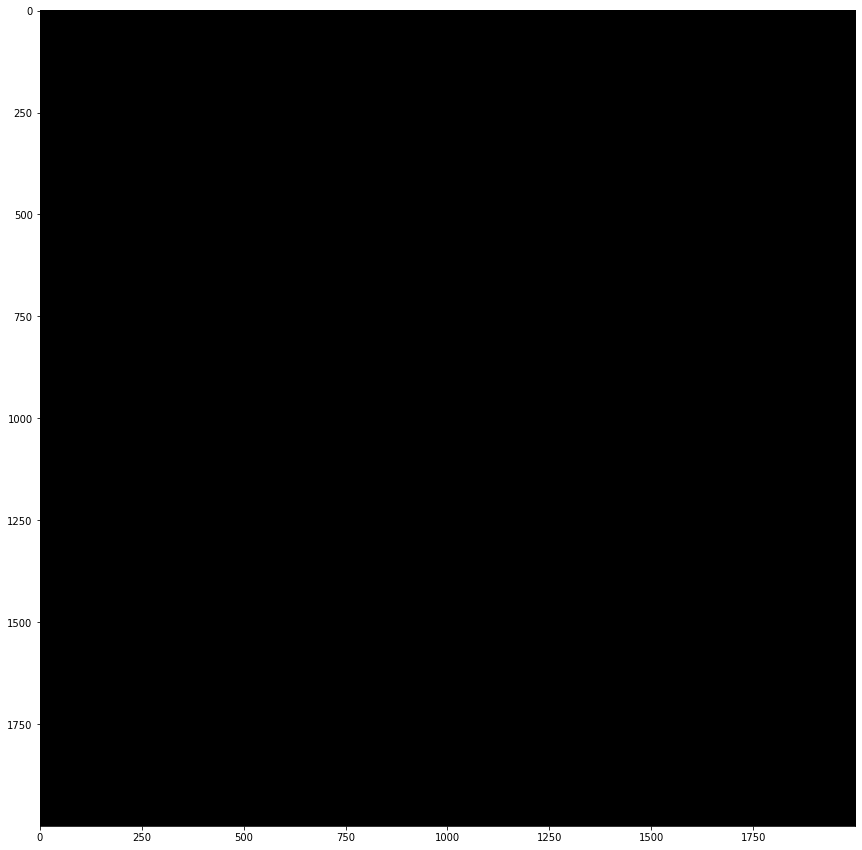

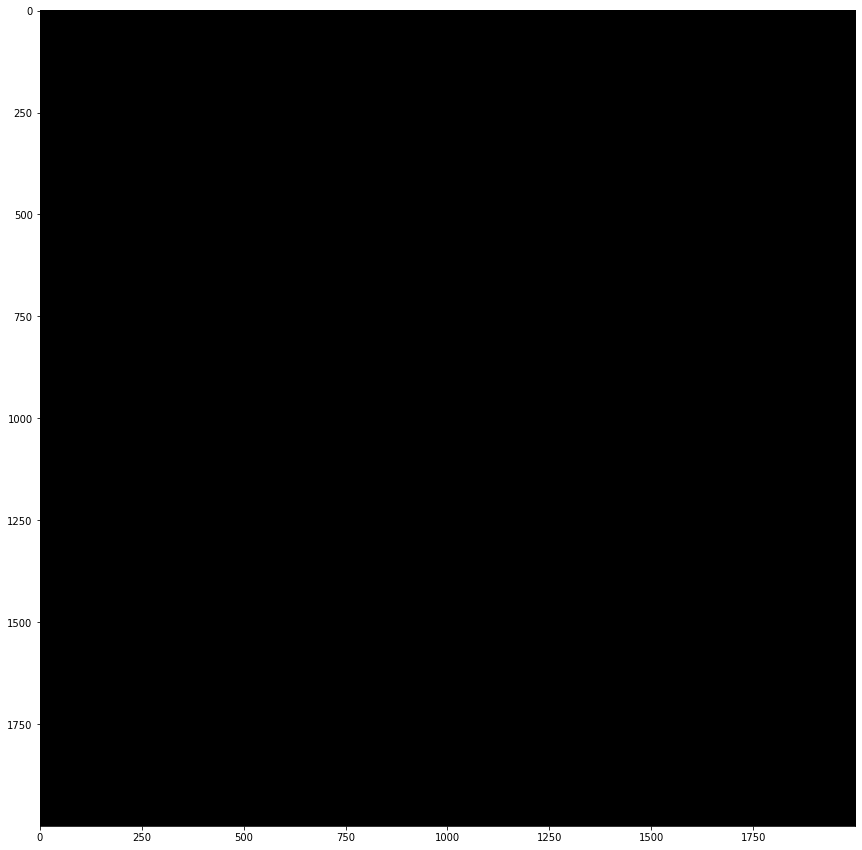

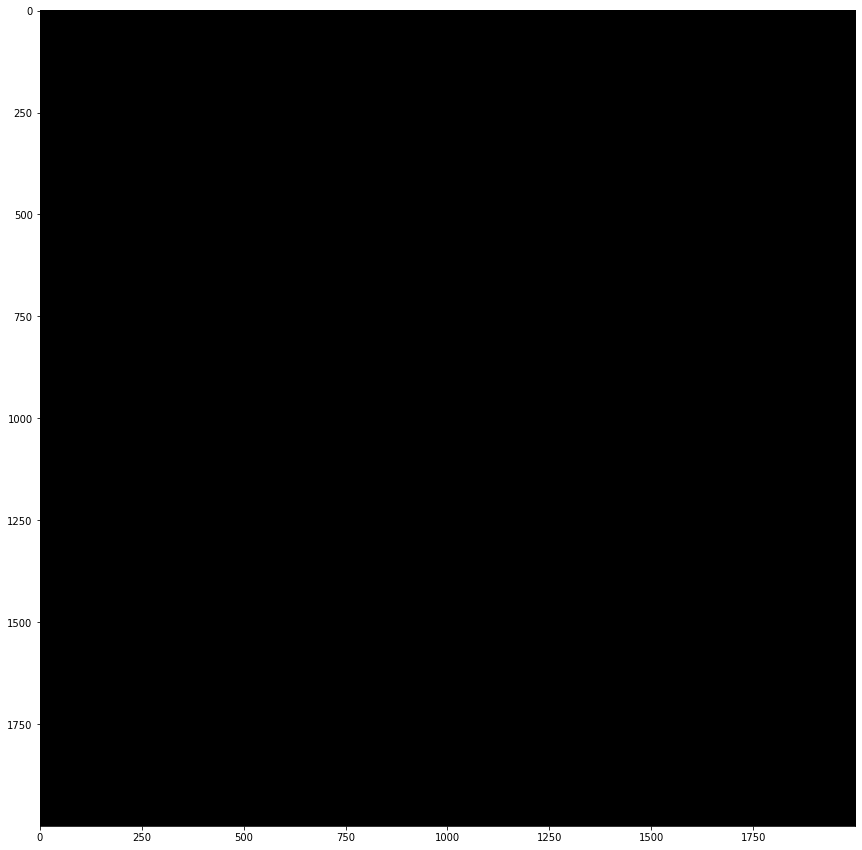

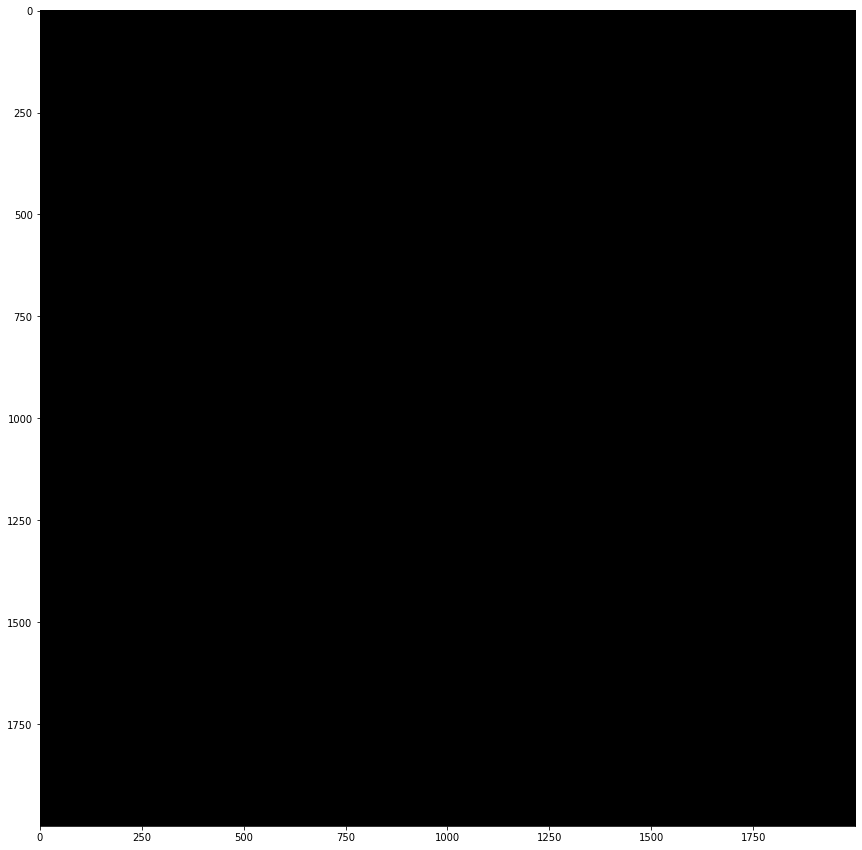

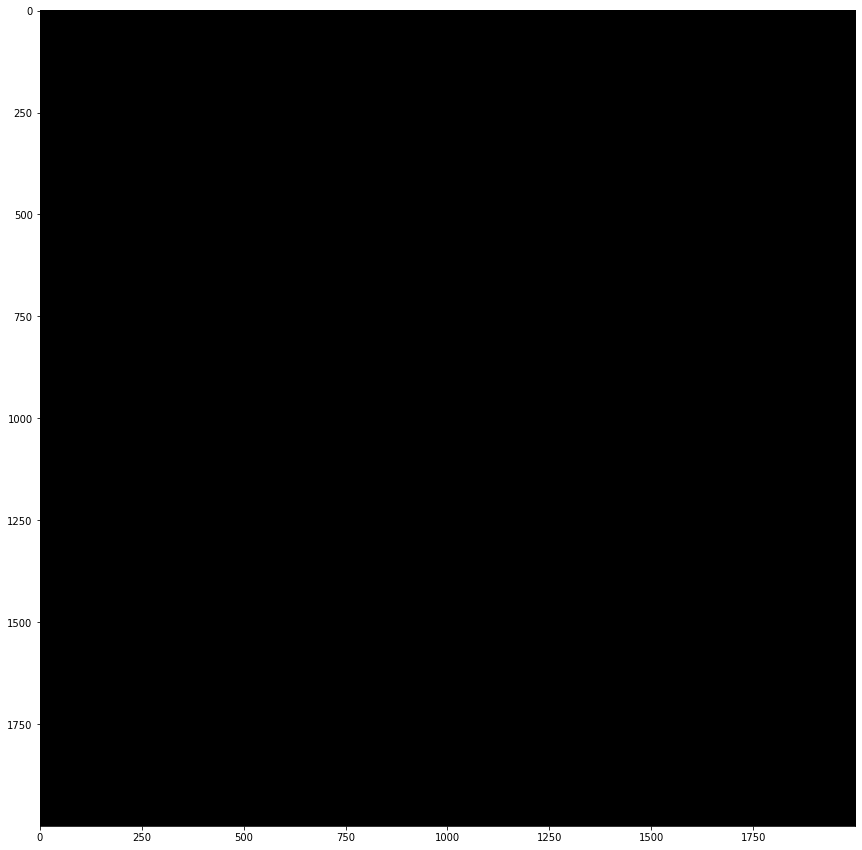

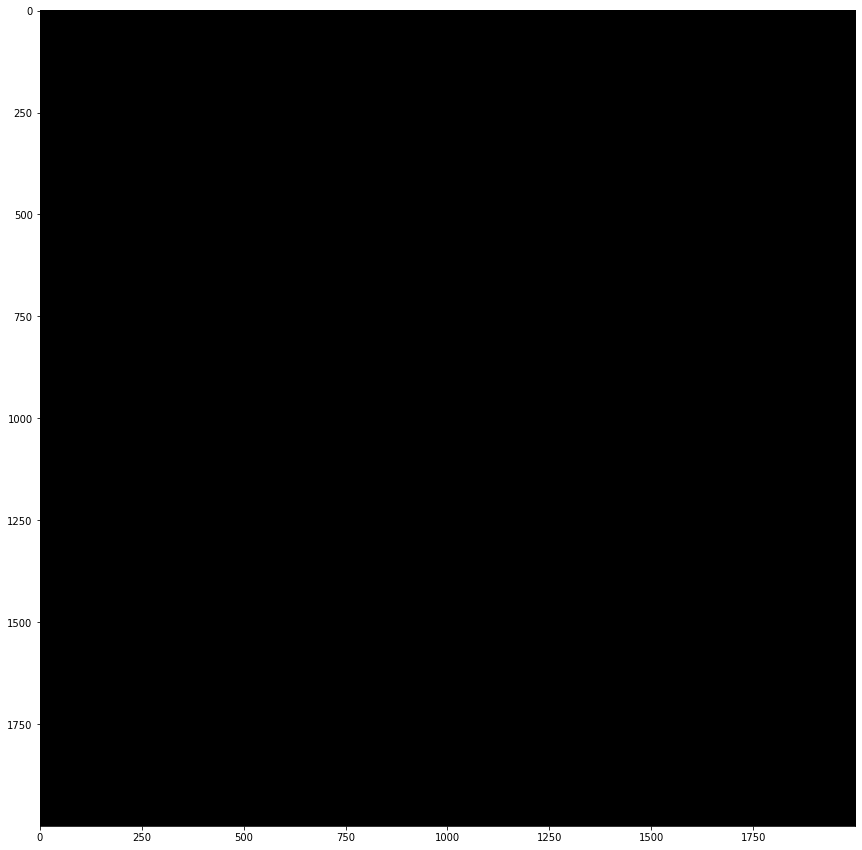

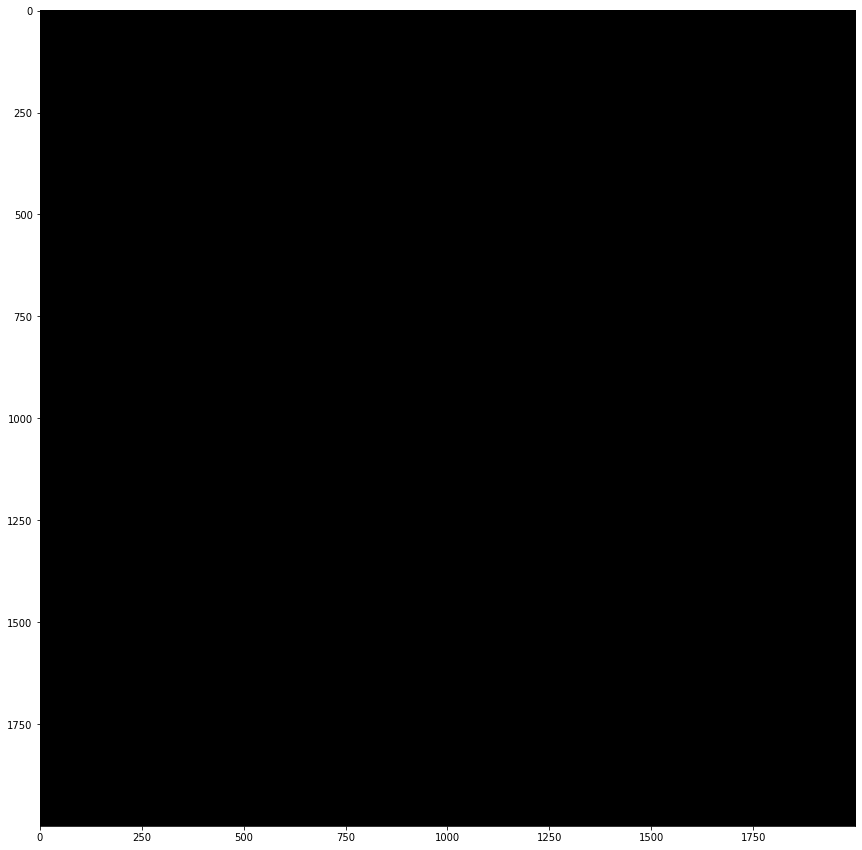

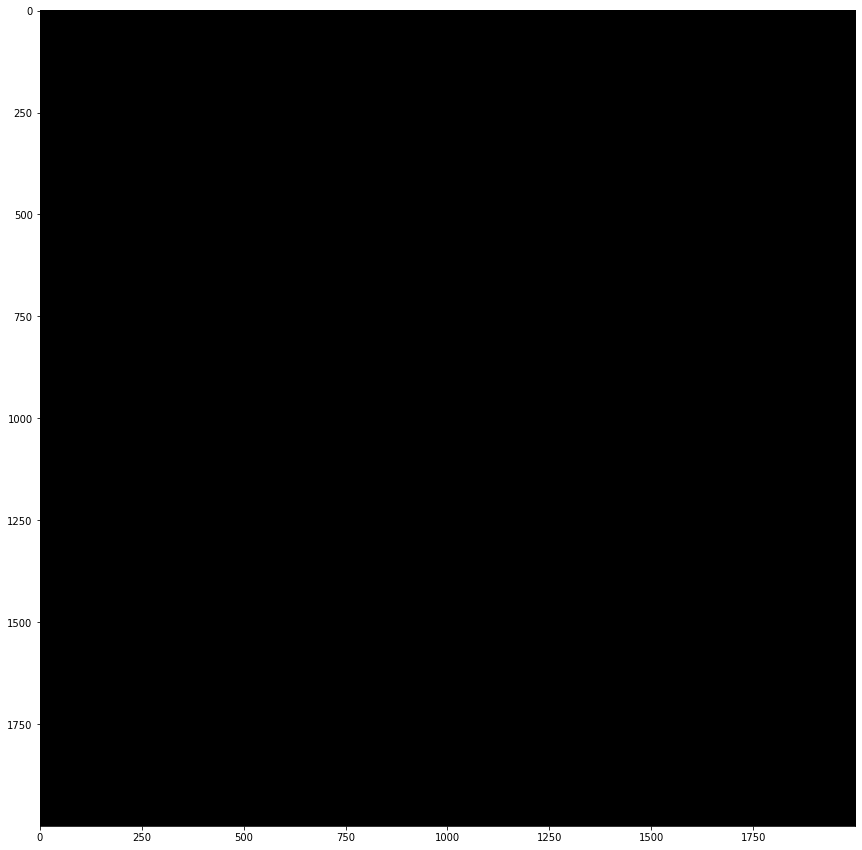

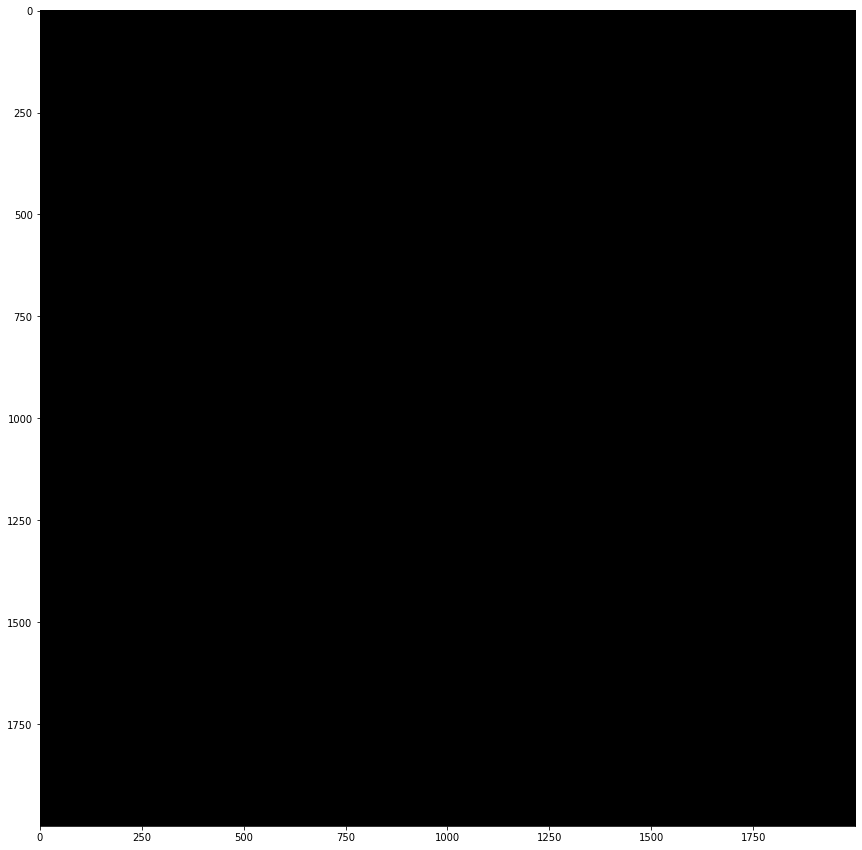

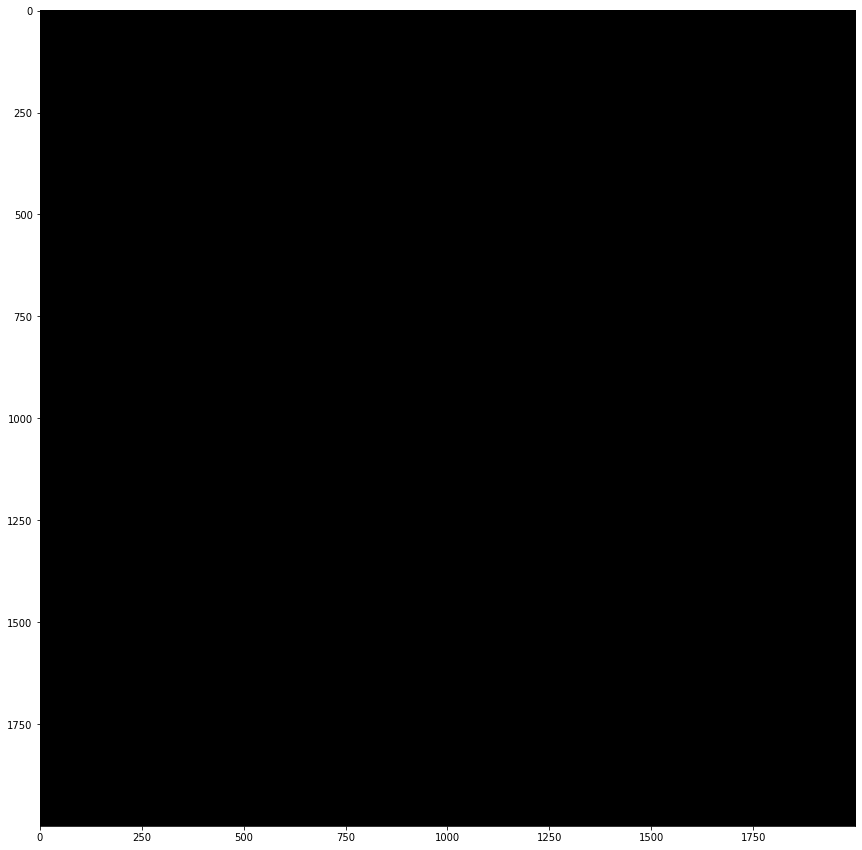

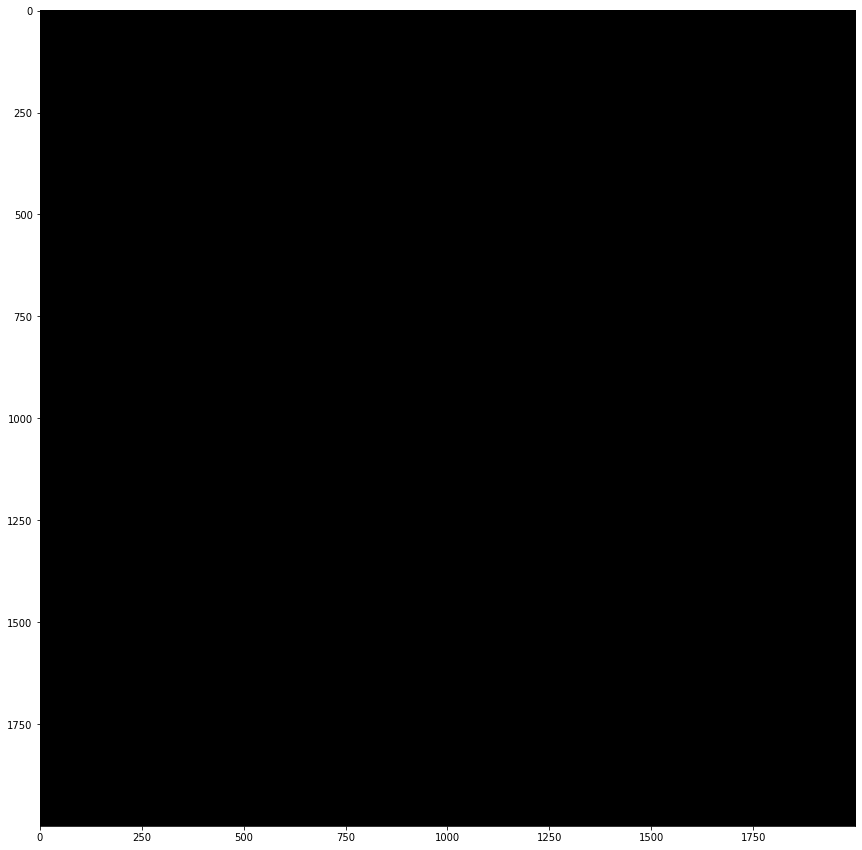

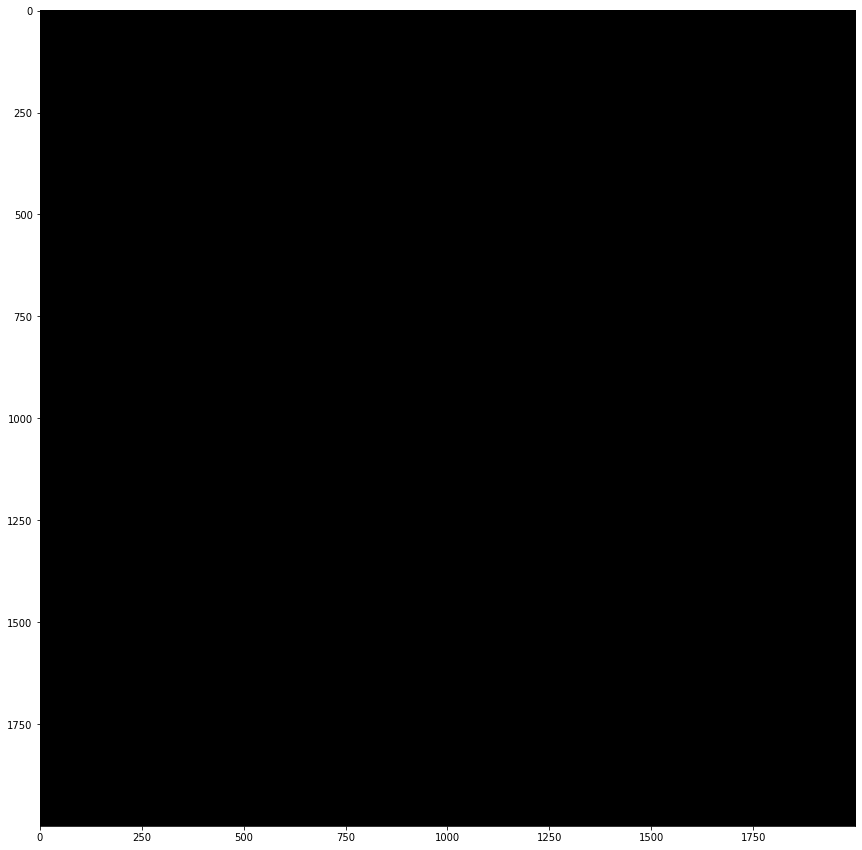

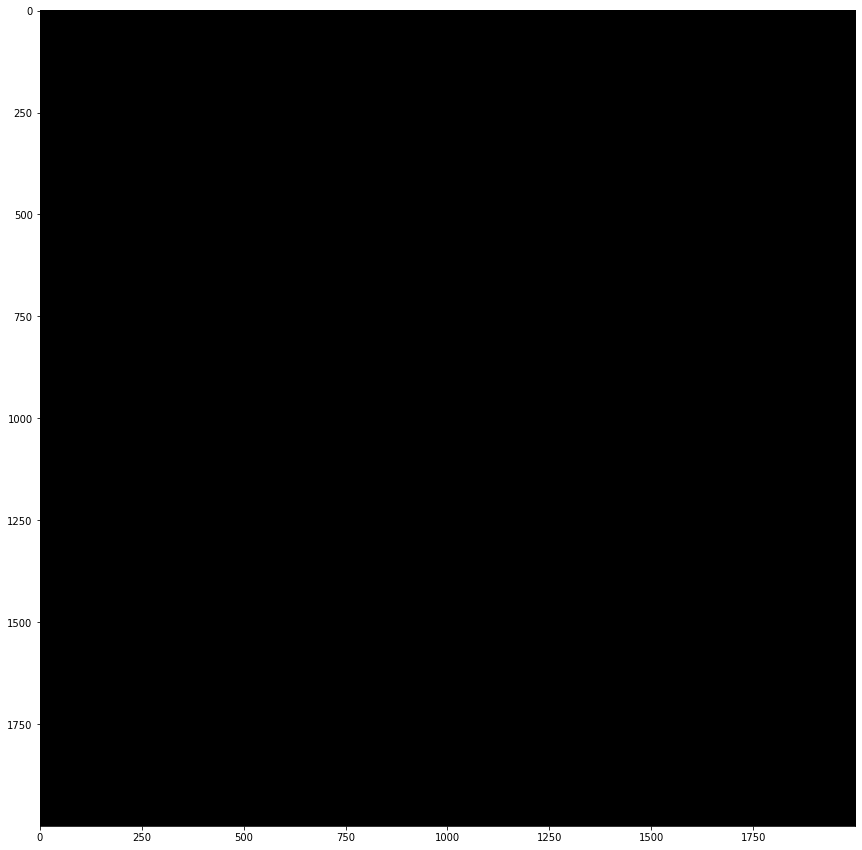

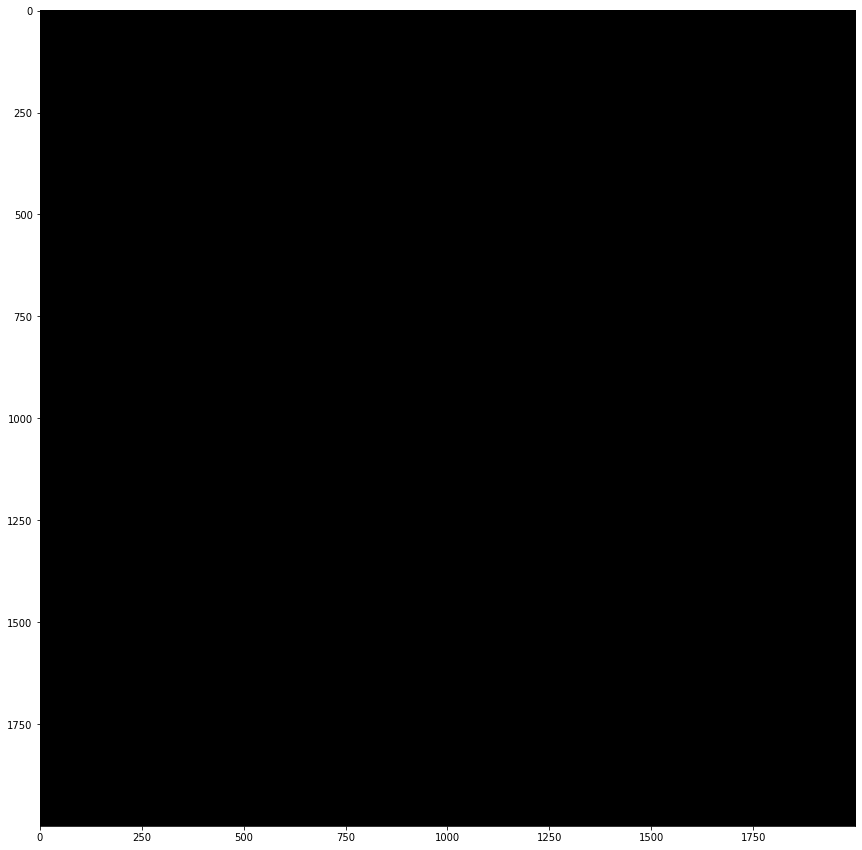

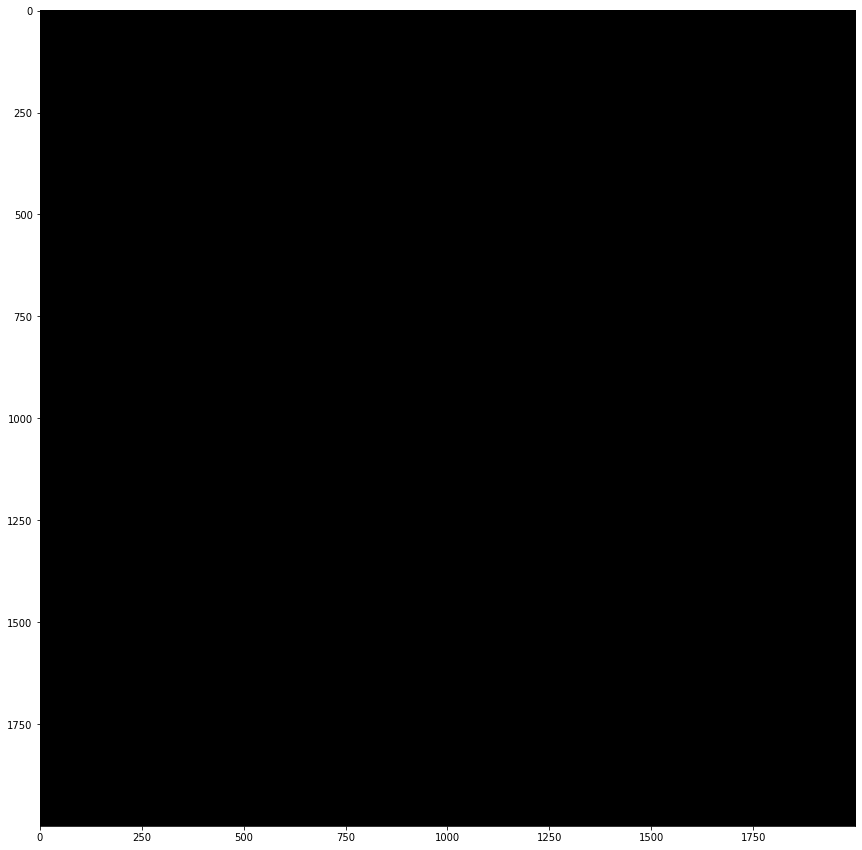

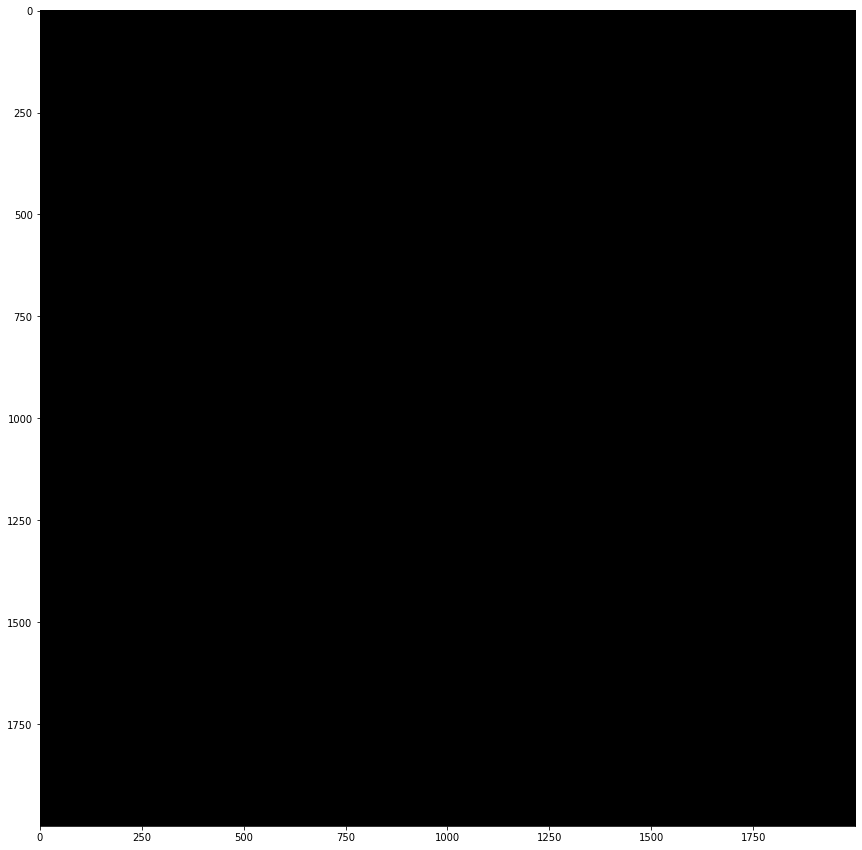

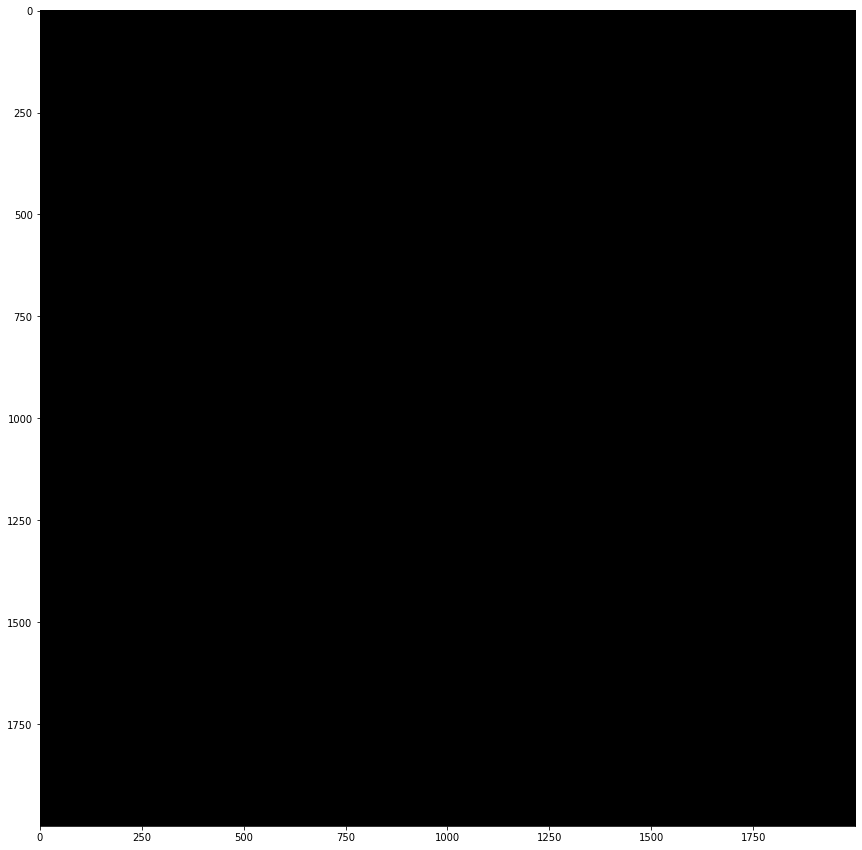

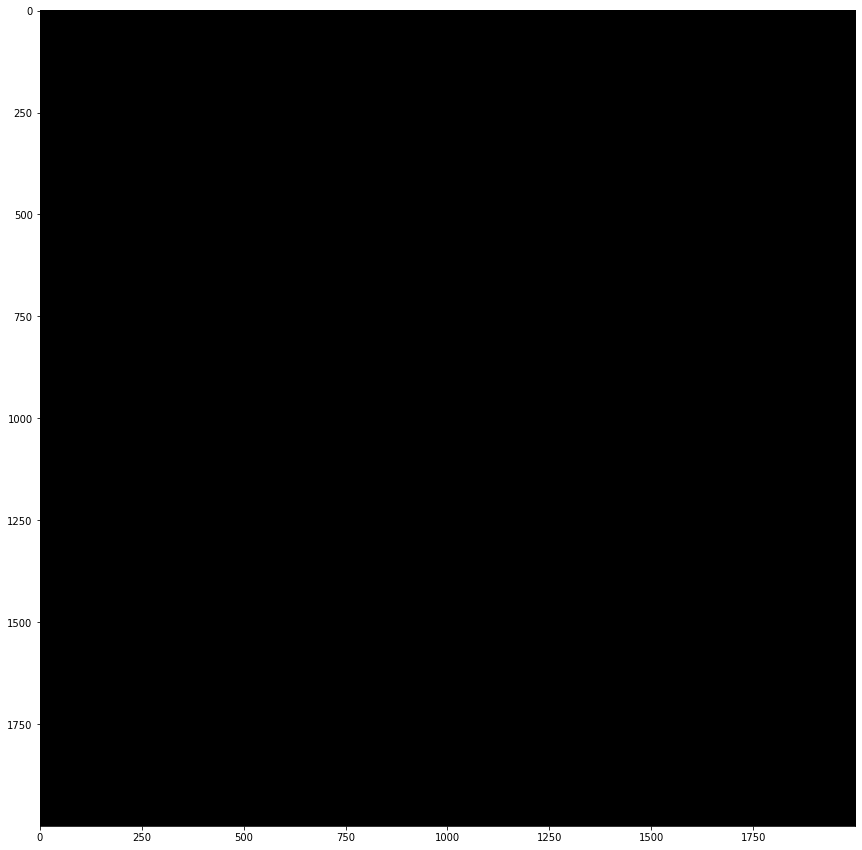

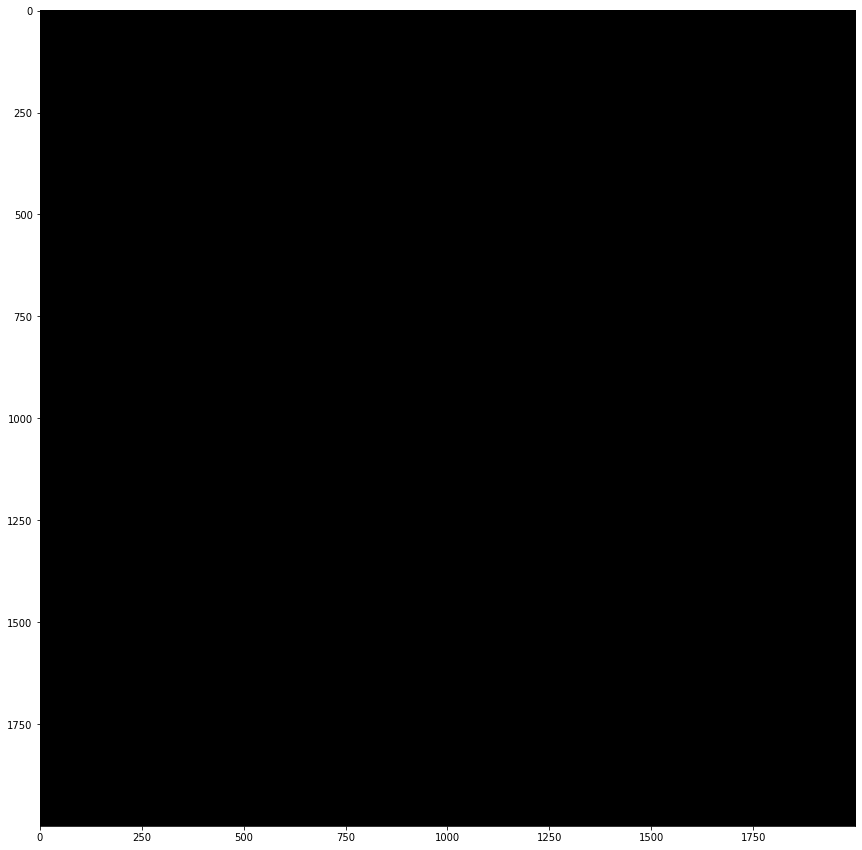

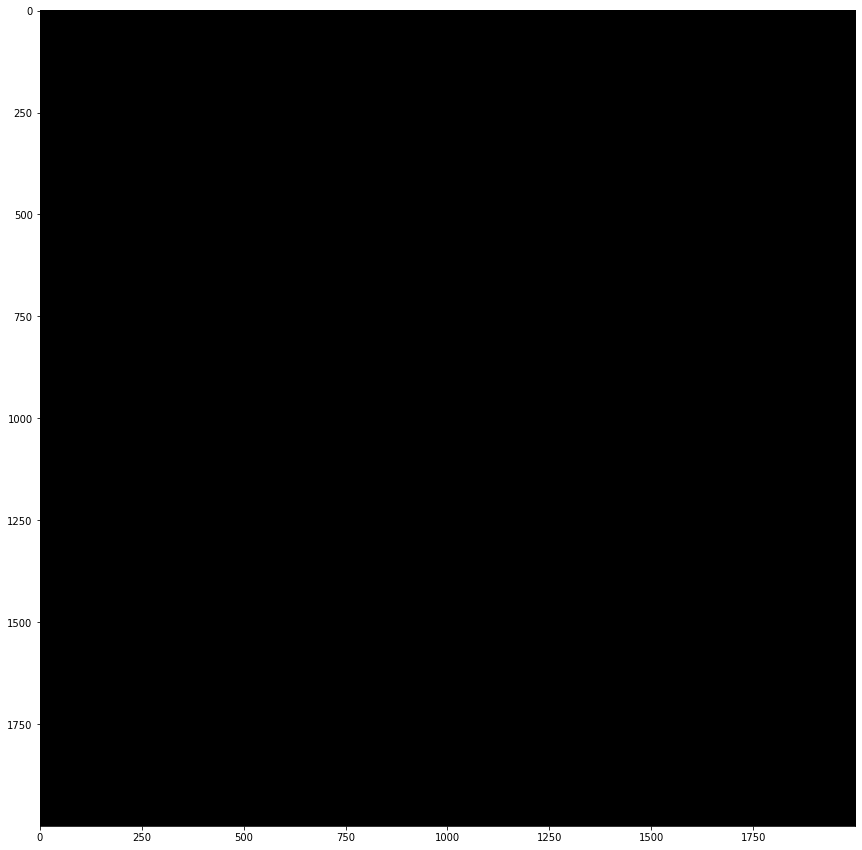

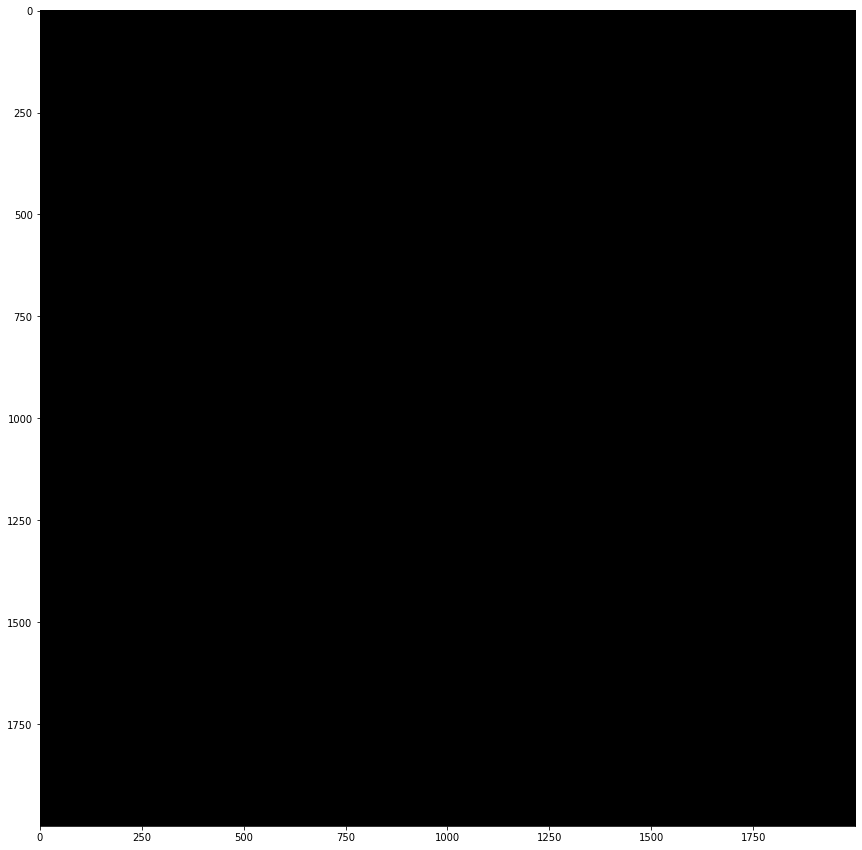

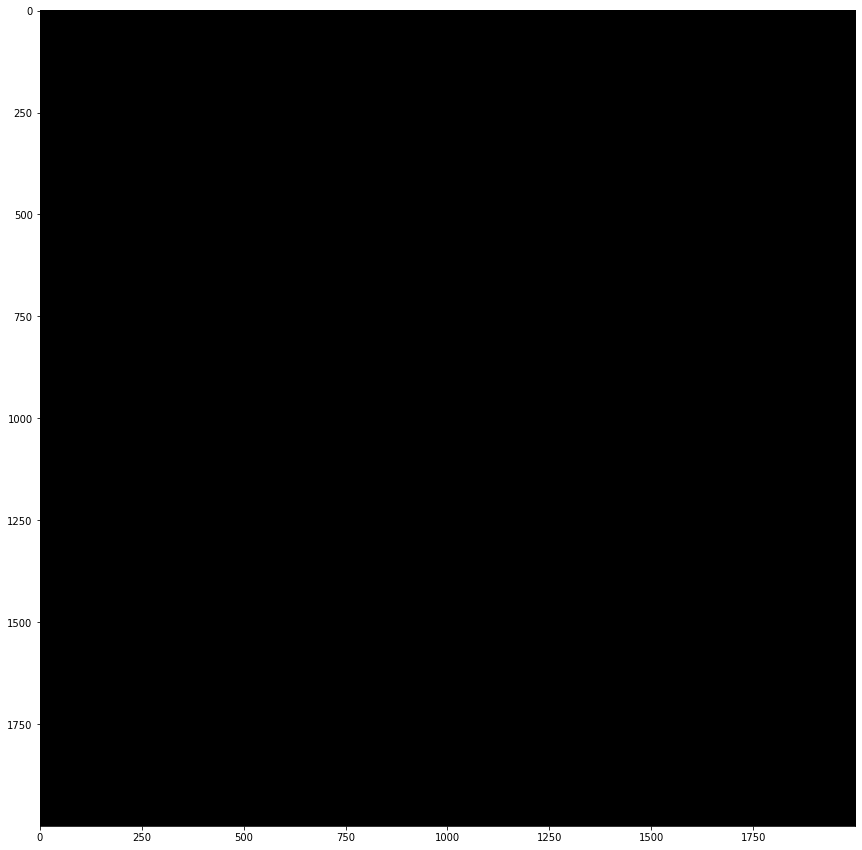

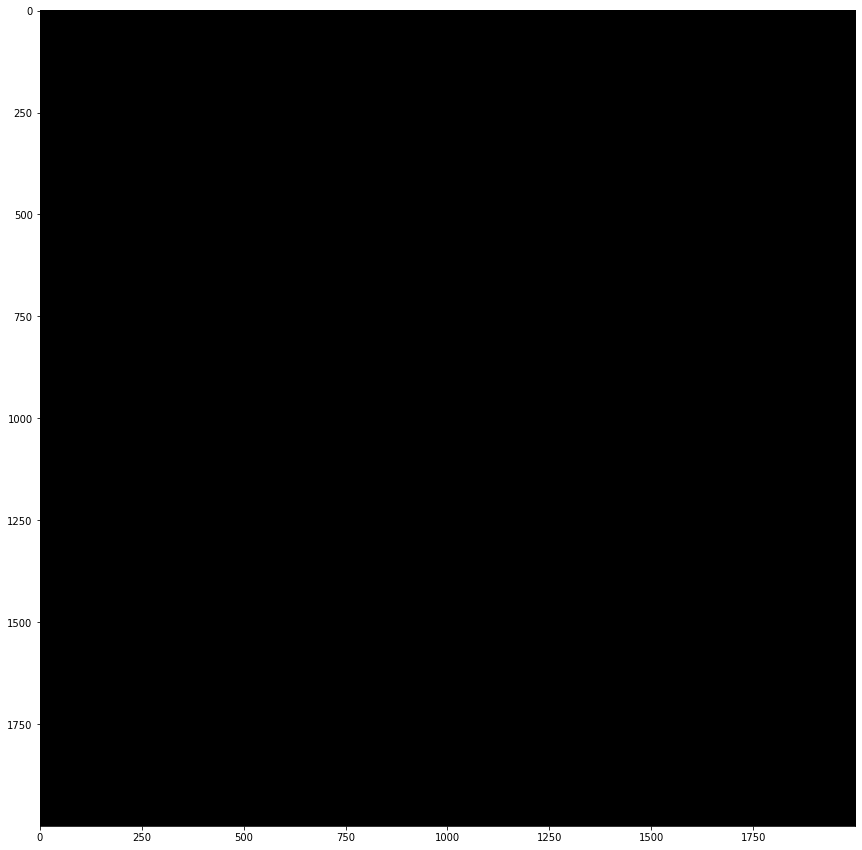

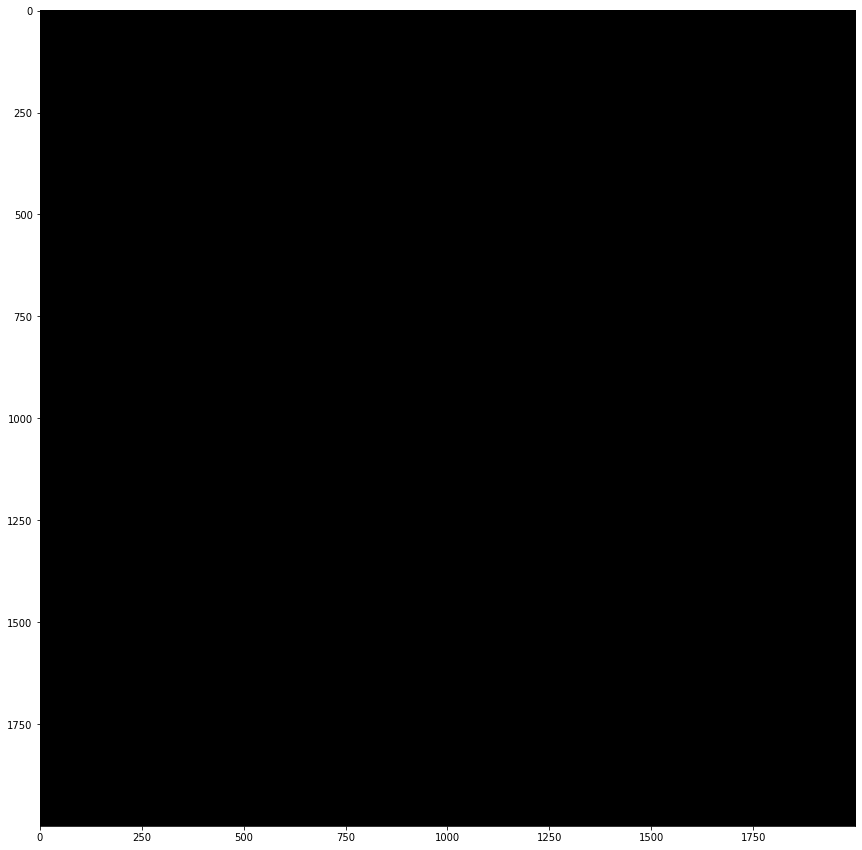

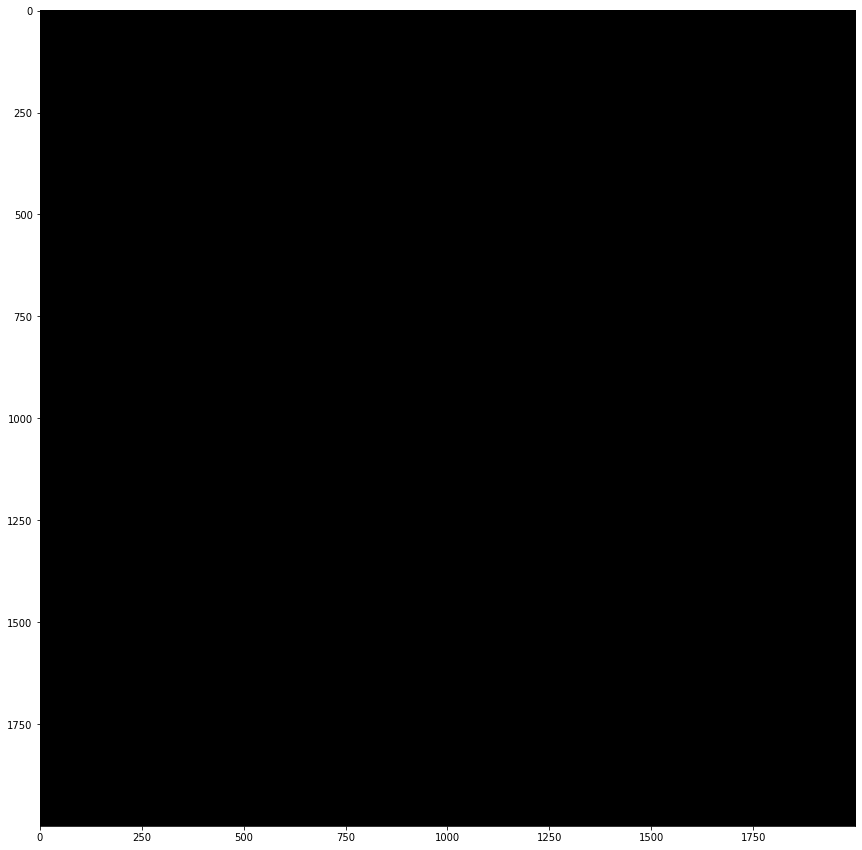

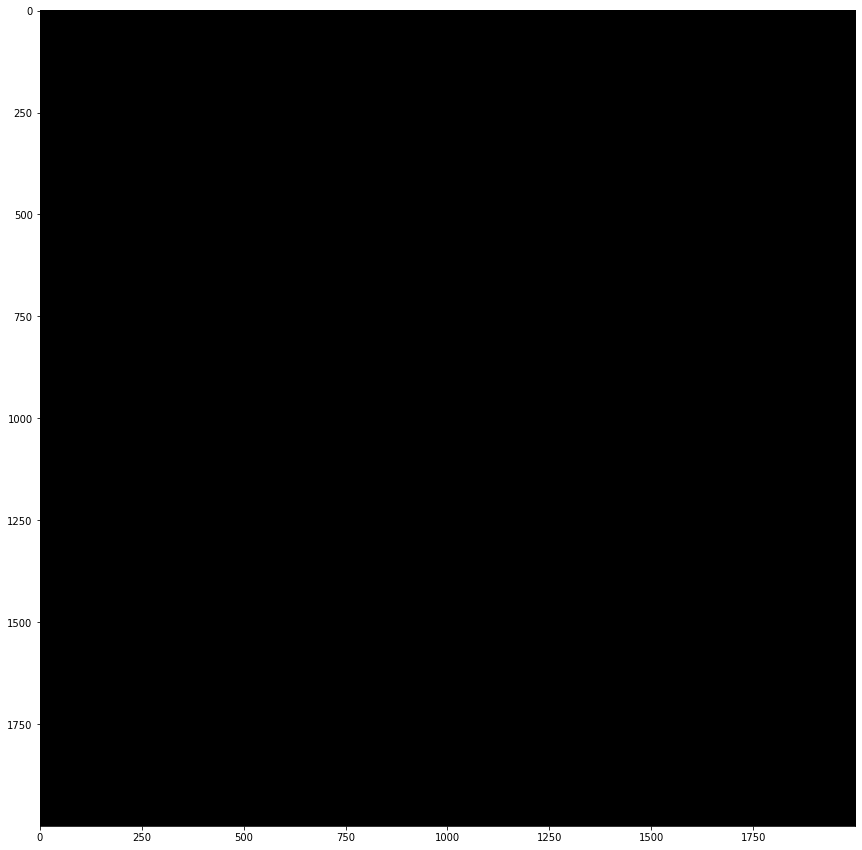

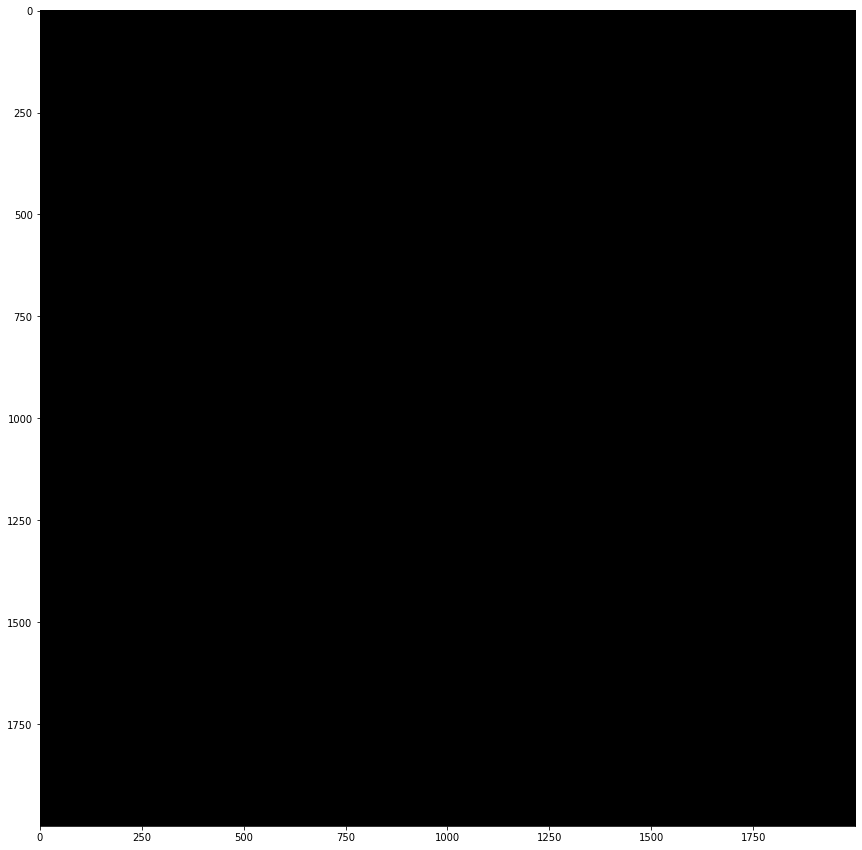

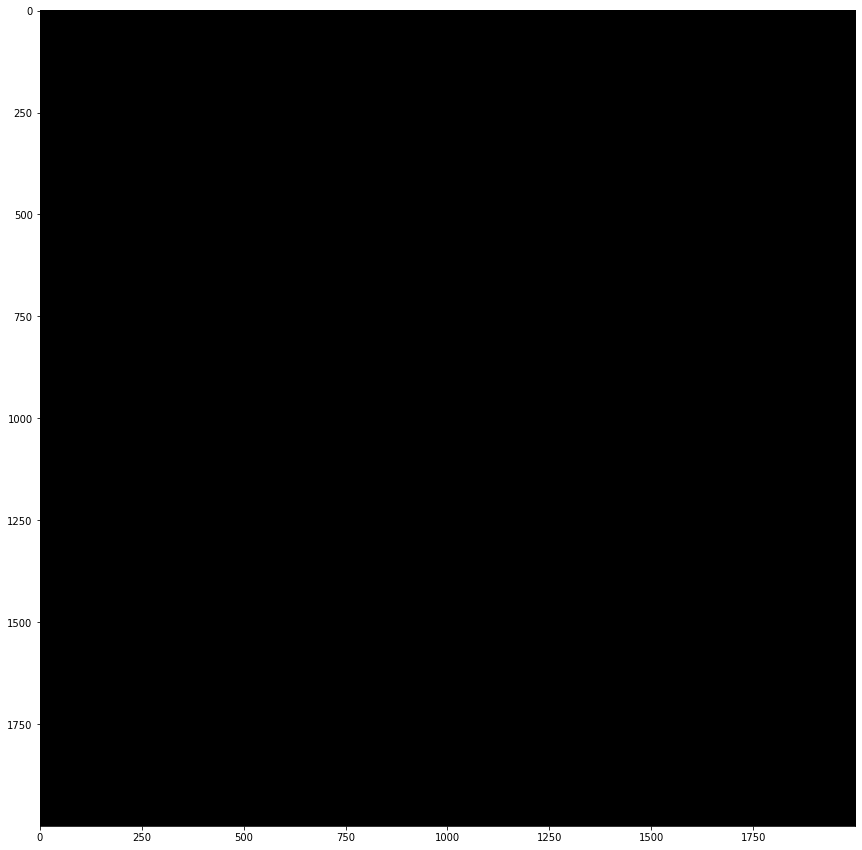

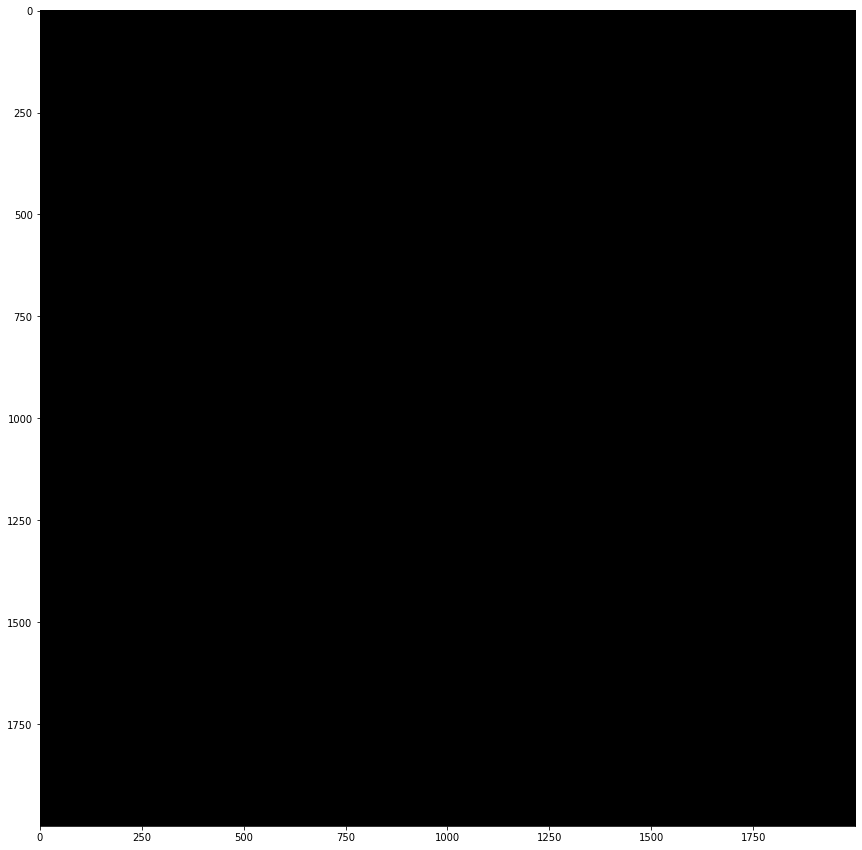

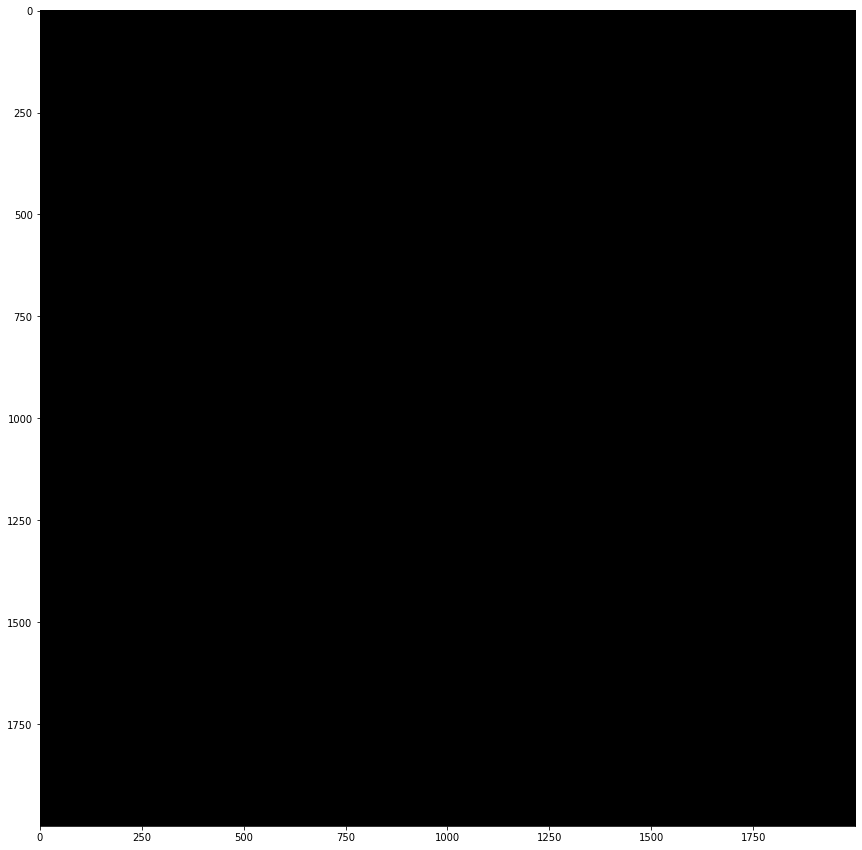

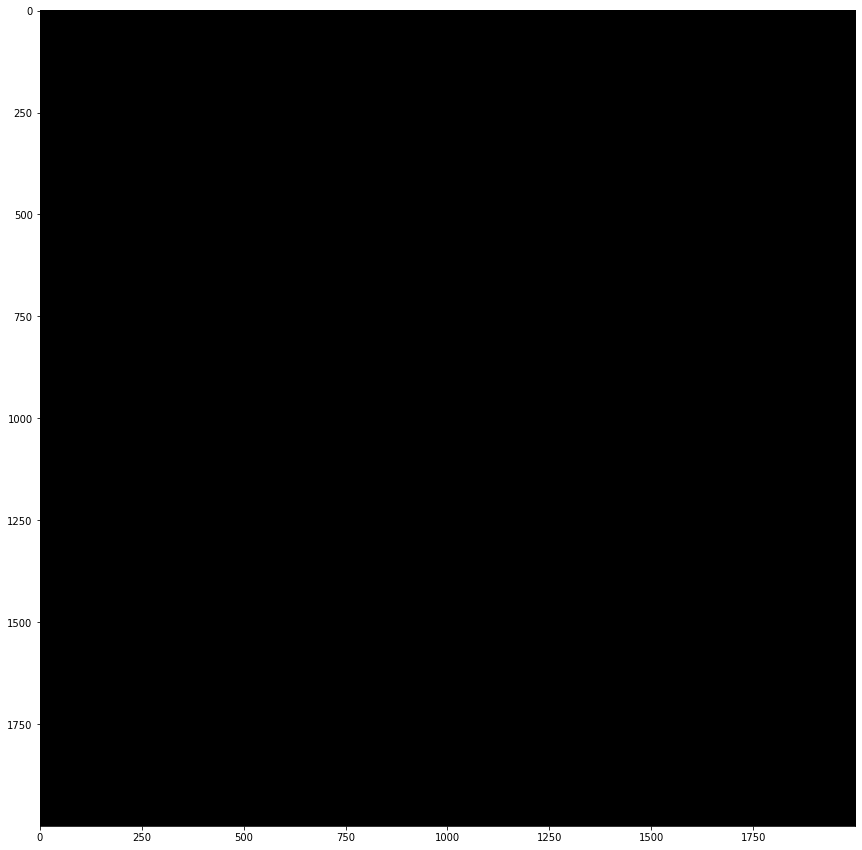

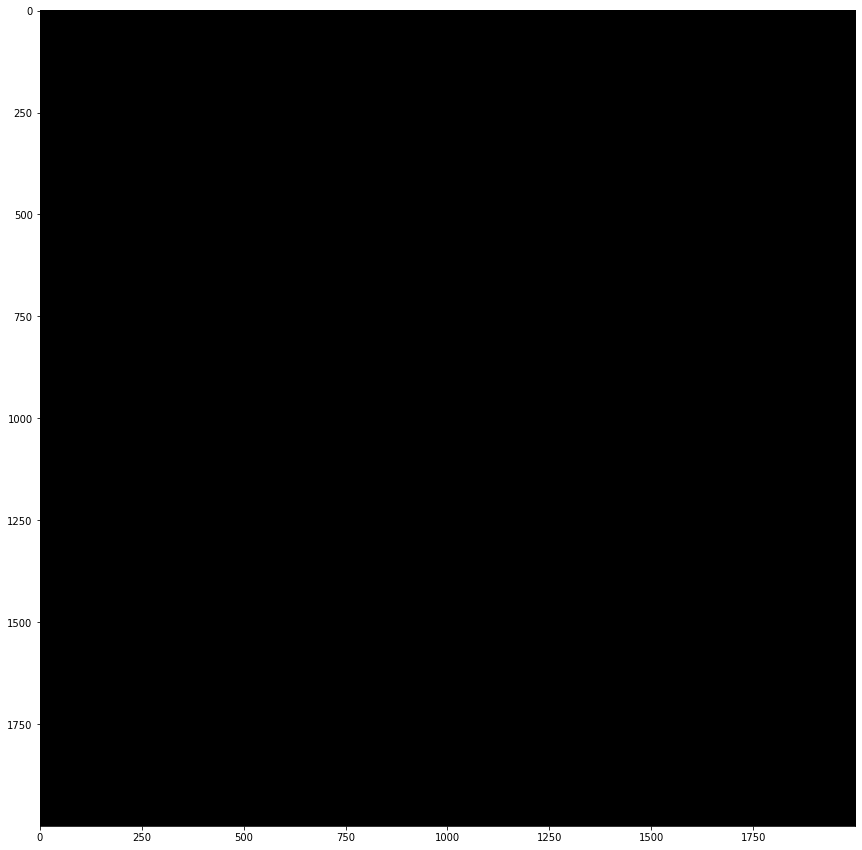

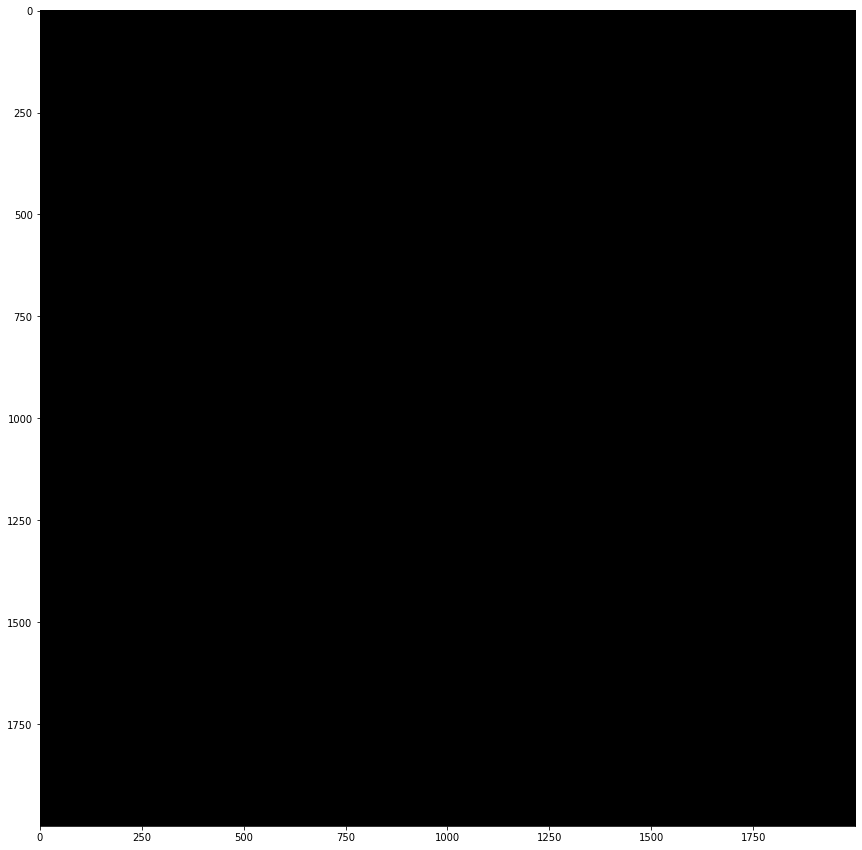

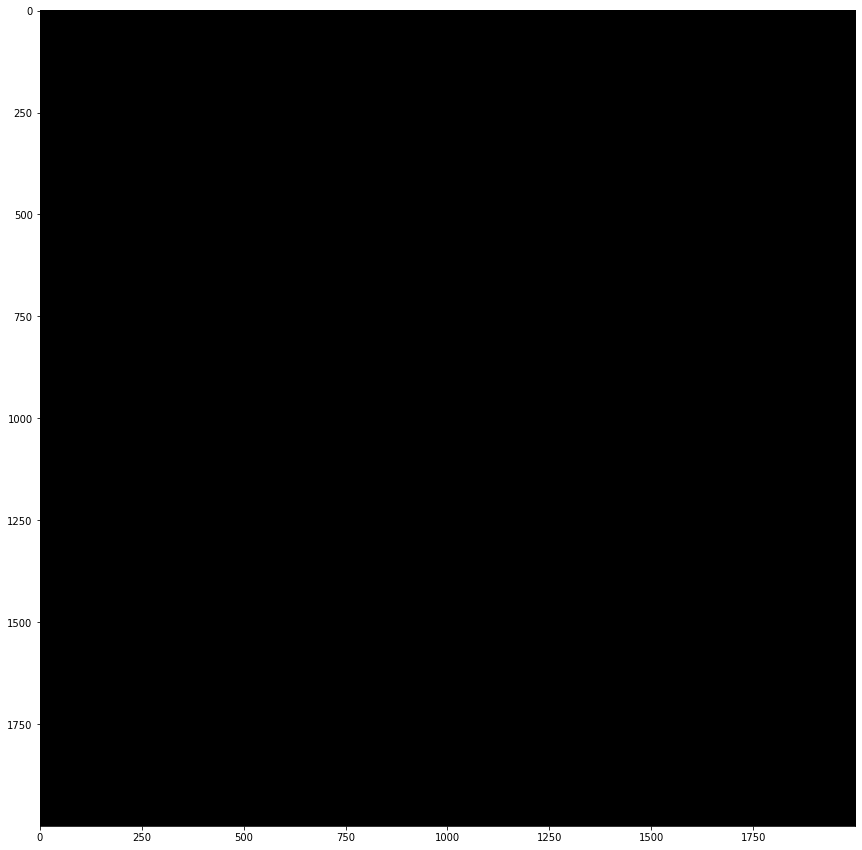

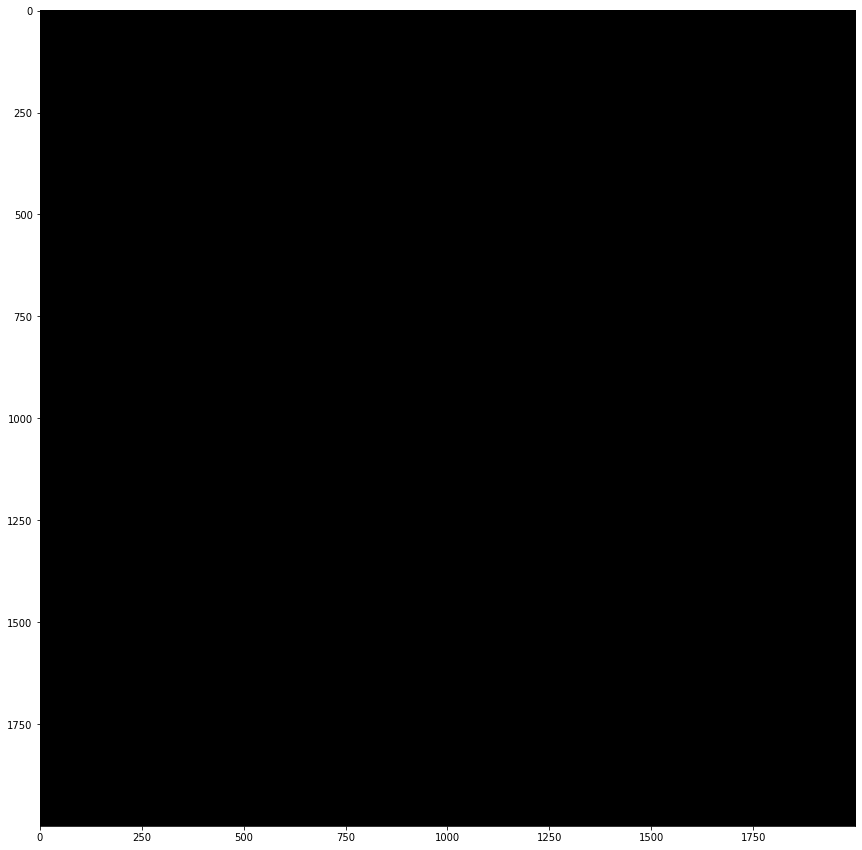

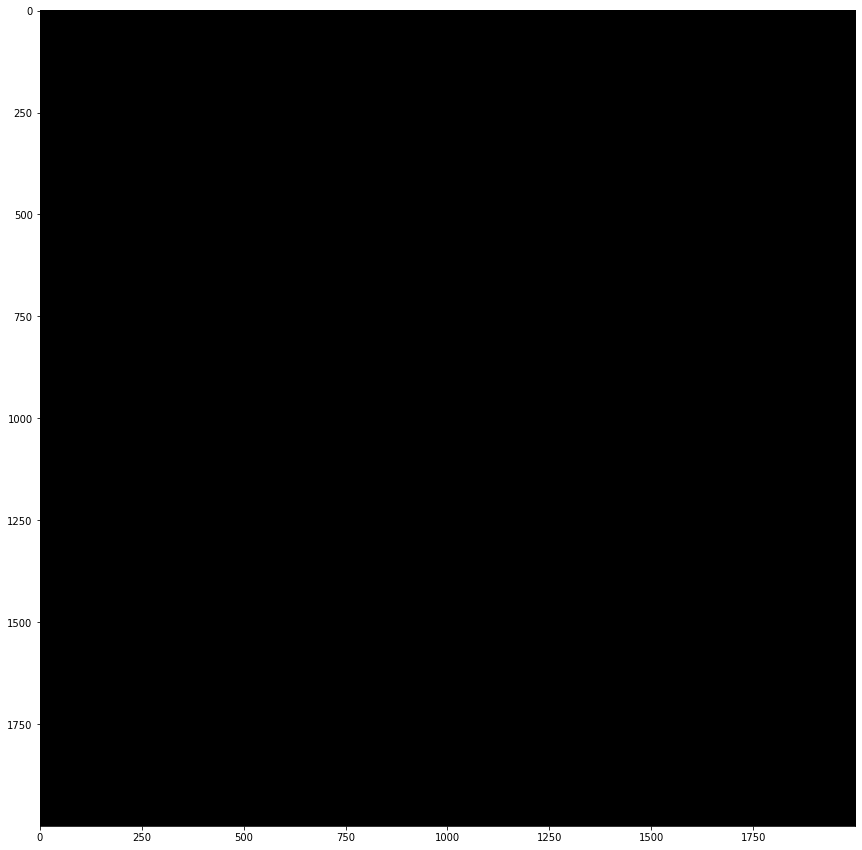

Error in callback <function flush_figures at 0x00000265F516E280> (for post_execute):


KeyboardInterrupt: 

In [52]:
#def colony_area(df,h,w):
h = 2000
w = 2000
df = x.colonies
for colony in df.mother_cell.unique():
    mask = np.zeros((h, w, 3), dtype="uint8")
    for cell in df[df.mother_cell==colony].itertuples():
        
        xloc = round(cell[5]/x.metadata['Dimensions'][0]*h*w)
        yloc = round(cell[6]/x.metadata['Dimensions'][1]*h*w)
        radius = round(cell[4]/x.metadata['Dimensions'][0]*h*w)
        
        cv2.circle(mask,center = (xloc,yloc),radius = radius,color = (255,255,255),thickness = -1)


#area = np.count_nonzero(mask)
    #return mask
#colony_area(x.colonies,2000,2000)